In [1]:
import xarray as xr
import matplotlib.pylab as plt
import Rbeast as rb
import numpy as np
import cartopy.crs as ccrss
import cartopy.feature as cf
import matplotlib as mpl
import pandas as pd
import my_funs
from sklearn.experimental import enable_iterative_imputer
from sklearn.neighbors import BallTree, DistanceMetric
from causalimpact import CausalImpact
import pickle
from sklearn.impute import IterativeImputer
from dask.diagnostics import ProgressBar
from tqdm import tqdm
from scipy import stats
from collections import Counter
import seaborn as sns

mpl.rcParams["mathtext.default"] = "regular"
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from my_funs import outliers_index

dir = "/data/home/hamiddashti/hamid/nasa_above/greeness/"

Initialization done!


/data/home/hamiddashti/hamid/nasa_above/greeness/codes/src/my_funs.py:9: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd
2023-09-04 07:43:19.728452: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the follo

Some handy functions

In [2]:
def year_detect(x):
    # Get the index of the first non-nan value
    if not np.any(x):
        return np.nan
    idx = np.argmax(x)
    return idx

def most_common_values(arr, n):
    # Count the n most repeated values in an array
    counter = Counter(arr)
    most_common = counter.most_common(n)
    return [value for value, _ in most_common]

## Read the data

In [3]:
percent = xr.open_dataset(
    "../data/percent_cover.nc")["__xarray_dataarray_variable__"].sel(
        time=slice(1984, 2013))
ndvi = xr.open_dataarray("../data/NDVI_resampled_v2.nc").sel(
    time=slice("1984", "2013")) / 10000
lai4g = xr.open_dataarray("../data/lai4g_annual_max.nc").sel(
    time=slice("1984", "2013"))
percent["lat"] = lai4g["lat"]
percent["lon"] = lai4g["lon"]
# Only focus on vegetative classes
lc = percent.isel(band=[0, 2, 3, 4, 5])
t_short = pd.date_range(start="1984", end="2014", freq="A-Dec").year
t = pd.date_range(start="1984", end="2014", freq="A-Dec").year
arr = xr.open_dataarray("../data/arr_id.nc")

### Distrubance and vegetation dynamic


In [4]:
# Find disturbed pixels
lc_diff = lc.diff("time")
net_change = lc_diff.where(lc_diff > 0.0).sum("band")
changed = (net_change >= 0.1).any(dim="time")
not_changed = (net_change < 0.1).all(dim="time")
mask_tmp = np.isfinite(lc).all(["band", "time"])
not_changed = not_changed.where(mask_tmp == True)
lc_changed = lc.where(changed == True)
lc_not_changed = lc.where(not_changed == True)
lc_changed_df = lc_changed.mean(["lat", "lon"]).to_pandas()

In [5]:
# Extract land cover time series over disturbed pixels and fit Rbeast

ef_region_mean = lc_changed.isel(band=0).mean(["lat", "lon"])
ef_region_mean_rbeast = rb.beast(ef_region_mean.values,
                                 season="none",
                                 start=1984,
                                 tseg_minlength=1)

sh_region_mean = lc_changed.isel(band=1).mean(["lat", "lon"])
sh_region_mean_rbeast = rb.beast(sh_region_mean.values,
                                 season="none",
                                 start=1984,
                                 tseg_minlength=1)
sparse_region_mean = lc_changed.isel(band=3).mean(["lat", "lon"])
sparse_region_mean_rbeast = rb.beast(sparse_region_mean.values,
                                     season="none",
                                     start=1984,
                                     tseg_minlength=1)

#-------------------------------------------------
# Extract some of the metrics from fitted Rbeast -
#-------------------------------------------------

Y_ef = ef_region_mean_rbeast.trend.Y  # Trend
CI_ef = ef_region_mean_rbeast.trend.CI  # Trend confidence interval
slp_ef = ef_region_mean_rbeast.trend.slp  # Vector of estimate slopes at each t
cpOccPr_ef = ef_region_mean_rbeast.trend.cpOccPr  # Probability of occurance of a change point
slpSgnPosPr_ef = ef_region_mean_rbeast.trend.slpSgnPosPr  # Sign of the slope
cpPr_ef = ef_region_mean_rbeast.trend.cpPr  # Probability associated to a detected change point
cp_ef = ef_region_mean_rbeast.trend.cp[
    cpPr_ef > 0.5]  # Detected change points with probability more than 50%
cpPr_ef = cpPr_ef[cpPr_ef > 0.5]

Y_sh = sh_region_mean_rbeast.trend.Y
CI_sh = sh_region_mean_rbeast.trend.CI
slp_sh = sh_region_mean_rbeast.trend.slp
cpOccPr_sh = sh_region_mean_rbeast.trend.cpOccPr
slpSgnPosPr_sh = sh_region_mean_rbeast.trend.slpSgnPosPr
cpPr_sh = sh_region_mean_rbeast.trend.cpPr
cp_sh = sh_region_mean_rbeast.trend.cp[cpPr_sh > 0.5]
cpPr_sh = cpPr_sh[cpPr_sh > 0.5]

Y_sparse = sparse_region_mean_rbeast.trend.Y
CI_sparse = sparse_region_mean_rbeast.trend.CI
slp_sparse = sparse_region_mean_rbeast.trend.slp
cpOccPr_sparse = sparse_region_mean_rbeast.trend.cpOccPr
slpSgnPosPr_sparse = sparse_region_mean_rbeast.trend.slpSgnPosPr
cpPr_sparse = sparse_region_mean_rbeast.trend.cpPr
cp_sparse = sparse_region_mean_rbeast.trend.cp[cpPr_sparse > 0.5]
cpPr_sparse = cpPr_sparse[cpPr_sparse > 0.5]

On the first run, check the CPU instruction set ... 

15
CPU Vendor:
    AMD         = No
    Intel       = Yes
 
OS Features:
    OS AVX      = Yes
    OS AVX512   = No

Hardware Features:
    MMX         = Yes
    x64         = Yes
    ABM         = Yes
    RDRAND      = Yes
    RDSEED      = No
    BMI1        = Yes
    BMI2        = Yes
    ADX         = No
    MPX         = No
    PREFETCHW   = No
    PREFETCHWT1 = No
    RDPID       = No
    GFNI        = No
    VAES        = No

SIMD: 128-bit
    SSE         = Yes
    SSE2        = Yes
    SSE3        = Yes
    SSSE3       = Yes
    SSE4a       = No
    SSE4.1      = Yes
    SSE4.2      = Yes
    AES-NI      = Yes
    SHA         = No

SIMD: 256-bit
    AVX         = Yes
    XOP         = No
    FMA3        = Yes
    FMA4        = No
    AVX2        = Yes

SIMD: 512-bit
    AVX512-F         = No
    AVX512-CD        = No
    AVX512-PF        = No
    AVX512-ER        = No
    AVX512-VL        = No
    AVX512-BW        = No
    A

Plot the disturbance dynamic


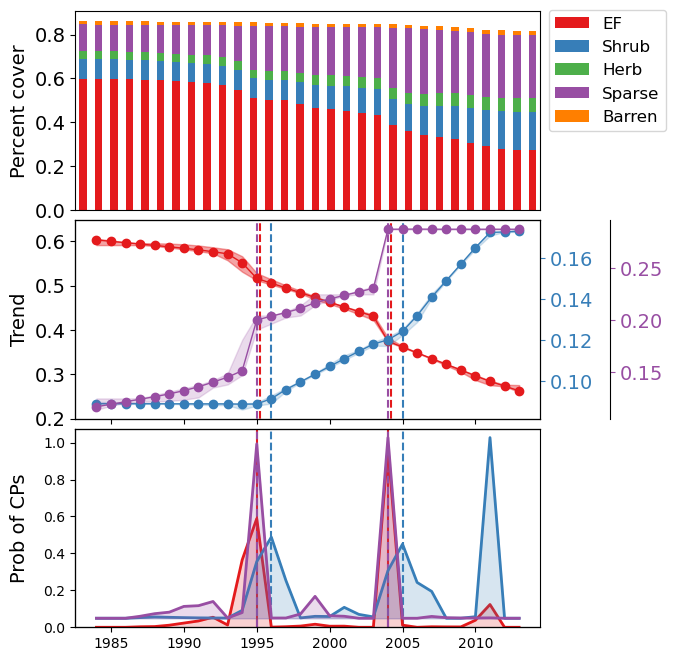

In [6]:
# Set default font size to 14
plt.rcParams.update({"font.size": 14})

# Set a distinct color palette
color_palette = sns.color_palette("Set1", n_colors=5)

names = ["EF", "Shrub", "Herb", "Sparse", "Barren"]

lc_changed_df.columns = names

# Create subplots
fig, ax = plt.subplots(3, 1, figsize=(6, 8), gridspec_kw={"wspace": 0.1, "hspace": 0.05})

# Plotting subplots
lc_changed_df.plot(ax=ax[0], kind="bar", stacked=True, legend=False, title="", color=color_palette)
ax[0].legend(title="", bbox_to_anchor=(1, 1.05), loc="upper left", fontsize=12)
ax[0].xaxis.set_tick_params(width=0)
ax[0].set_ylabel("Percent cover")

ax[1].plot(t, Y_ef, color=color_palette[0], linewidth=1, marker='o')
ax[1].fill_between(t, CI_ef[:, 0], CI_ef[:, 1], color=color_palette[0], alpha=0.4)
ax[1].set_xticklabels([])
ax[1].set_ylabel("Trend")
ax[1].set_ylim([np.min(ef_region_mean.values), np.max(ef_region_mean.values)])
ax[1].set_ylim(0.2, np.max(ef_region_mean.values) + 0.05)
ax[1].vlines(cp_sh, 0, np.max(ef_region_mean.values + 0.05), color=color_palette[1], linestyle="--")
ax[1].vlines(cp_sparse, 0, np.max(ef_region_mean.values + 0.05), color=color_palette[3], linestyle="--")
ax[1].vlines(cp_ef + 0.2, 0, np.max(ef_region_mean.values + 0.05), color=color_palette[0], linestyle="--")

ax02 = ax[1].twinx()
ax02.plot(t, Y_sh, color=color_palette[1], linewidth=1, marker='o')
ax02.fill_between(t, CI_sh[:, 0], CI_sh[:, 1], color=color_palette[1], alpha=0.2)
ax02.tick_params(axis="both", which="major", labelsize=14,colors=color_palette[1])

ax03 = ax[1].twinx()
ax03.spines.right.set_position(("axes", 1.15))
ax03.plot(t, Y_sparse, color=color_palette[3], linewidth=1, marker='o')
ax03.fill_between(t, CI_sparse[:, 0], CI_sparse[:, 1], color=color_palette[3], alpha=0.2)
ax03.tick_params(axis="both", which="major", labelsize=14,colors=color_palette[3])

ax[2].plot(t, cpOccPr_ef, linewidth=2, color=color_palette[0])
ax[2].set_ylabel("Prob of CPs")
ax[2].set_ylim([0, np.max(cpOccPr_ef) + 0.1])
ax[2].tick_params(axis="both", which="major", labelsize=10)
ax[2].fill_between(t, cpOccPr_ef, color=color_palette[0], alpha=0.2)

ax04 = ax[2].twinx()
ax04.plot(t, cpOccPr_sh, linewidth=2, color=color_palette[1])
ax04.fill_between(t, cpOccPr_sh, color=color_palette[1], alpha=0.2)
ax04.set_yticklabels([])
ax04.spines['right'].set_visible(False)
ax04.yaxis.set_ticks_position('none')

ax05 = ax[2].twinx()
ax05.spines.right.set_position(("axes", 1.15))
ax05.plot(t, cpOccPr_sparse, linewidth=2, color=color_palette[3])
ax05.fill_between(t, cpOccPr_sparse, color=color_palette[3], alpha=0.2)
ax05.set_yticklabels([])
ax05.spines['right'].set_visible(False)
ax05.yaxis.set_ticks_position('none')

ax[2].vlines(cp_ef, 0, np.max(cpOccPr_ef) + 0.1, color=color_palette[0], linestyle="-")
ax[2].vlines(cp_sh, 0, np.max(cpOccPr_sh) + 0.1, color=color_palette[1], linestyle="--")
ax[2].vlines(cp_sparse, 0, np.max(cpOccPr_sparse) + 0.1, color=color_palette[3], linestyle="--")

# Align y-labels
fig.align_ylabels()
plt.savefig("../manuscript/figures/regional_mean_LC_rbeast.png", bbox_inches="tight", pad_inches=0.1)

Plot the dynamic of NDVI and LAI over disturbed areas


In [7]:
ndvi_changed = ndvi.where(changed == True)
ndvi_not_changed = ndvi.where(not_changed == True)
I = (np.isfinite(ndvi_changed).sum(dim="time") > 25)
ndvi_ok = ndvi_changed.where(I == True)

Apply Rbeast on NDVI

In [8]:
metadata = rb.args(whichDimIsTime=1, season="none", startTime=1984)
prior = rb.args(trendMinSepDist=1)
mcmc = rb.args(seed=1)
extra = rb.args(  # a set of options to specify the outputs or computational configurations
    dumpInputData=
    True,  # make a copy of the aggregated input data in the beast ouput
    numThreadsPerCPU=2,  # Paralell  computing: use 2 threads per cpu core
    numParThreads=
    0,  # `0` means using all CPU cores: total num of ParThreads = numThreadsPerCPU * core Num
    printOptions=False,
    computeTrendSlope=True,
    computeCredible=True)
ndvi_changed_rbeast = rb.beast123(ndvi_ok.values, metadata, prior, mcmc, extra)


Parallel computing: thread#1  generated ... 
Parallel computing: thread#2  generated ... 
Parallel computing: thread#3  generated ... 
Parallel computing: thread#4  generated ... 
Parallel computing: thread#5  generated ... 
Parallel computing: thread#6  generated ... 
Parallel computing: thread#7  generated ... 
Parallel computing: thread#8  generated ... 
Parallel computing: thread#9  generated ... 
Parallel computing: thread#10 generated ... 
Parallel computing: thread#11 generated ... 
Parallel computing: thread#12 generated ... 
Parallel computing: thread#13 generated ... 
Parallel computing: thread#14 generated ... 
Parallel computing: thread#15 generated ... 
Parallel computing: thread#16 generated ... 
Parallel computing: thread#17 generated ... 
Parallel computing: thread#18 generated ... 
Parallel computing: thread#19 generated ... 
Parallel computing: thread#20 generated ... 
Parallel computing: thread#21 generated ... 
Parallel computing: thread#22 generated ... 
Parallel c

In [9]:
Y_ndvi = ndvi_changed_rbeast.trend.Y.reshape(30, -1)
y_ndvi_mean = pd.DataFrame(Y_ndvi, index=t).dropna(axis=1).mean(axis=1)
y_ndvi_std = pd.DataFrame(Y_ndvi, index=t).dropna(axis=1).std(axis=1)

slp_ndvi = ndvi_changed_rbeast.trend.slp  # Vector of estimate slopes at each t
cpOccPr_ndvi = ndvi_changed_rbeast.trend.cpOccPr  # Probability of occurance of a change point
slpSgnPosPr_ndvi = ndvi_changed_rbeast.trend.slpSgnPosPr  # Sign of the slope
cpPr_ndvi = ndvi_changed_rbeast.trend.cpPr  # Probability associated to a detected change point
# cp_ndvi = ndvi_changed_rbeast.trend.cp[
#     cpPr_ndvi > 0.5]  # Detected change points with probability more than 50%
cp_ndvi = ndvi_changed_rbeast.trend.cp  # Detected change points with probability more than 50%
# cpPr_ndvi = cpPr_ndvi[cpPr_ndvi > 0.5]
ci_ndvi_0 = ndvi_changed_rbeast.trend.CI[:, 0, :, :]
ci_ndvi_1 = ndvi_changed_rbeast.trend.CI[:, 1, :, :]

cp_ndvi = pd.DataFrame(
    ndvi.isel(time=range(9)).copy(data=cp_ndvi).isel(time=0).stack(
        z=["lat", "lon"]).values).dropna()
slp_pos_mean = ndvi.copy(data=ndvi_changed_rbeast.trend.slpSgnPosPr).mean(
    ["lat", "lon"]).values
slp_pos_std = ndvi.copy(data=ndvi_changed_rbeast.trend.slpSgnPosPr).std(
    ["lat", "lon"]).values
slp_zero_mean = ndvi.copy(data=ndvi_changed_rbeast.trend.slpSgnZeroPr).mean(
    ["lat", "lon"]).values
slp_neg_mean = 1 - (slp_pos_mean + slp_zero_mean)

slp_ndvi_sd = ndvi.copy(data=ndvi_changed_rbeast.trend.slpSD).mean(
    ["lat", "lon"]).values
most_common_years = most_common_values(cp_ndvi.values.squeeze(), 2)
slp_ndvi_pd = ndvi.copy(data=slp_ndvi).mean(["lat", "lon"])
ci_ndvi_0_pd = ndvi.copy(data=ci_ndvi_0).mean(["lat", "lon"])
ci_ndvi_1_pd = ndvi.copy(data=ci_ndvi_1).mean(["lat", "lon"])

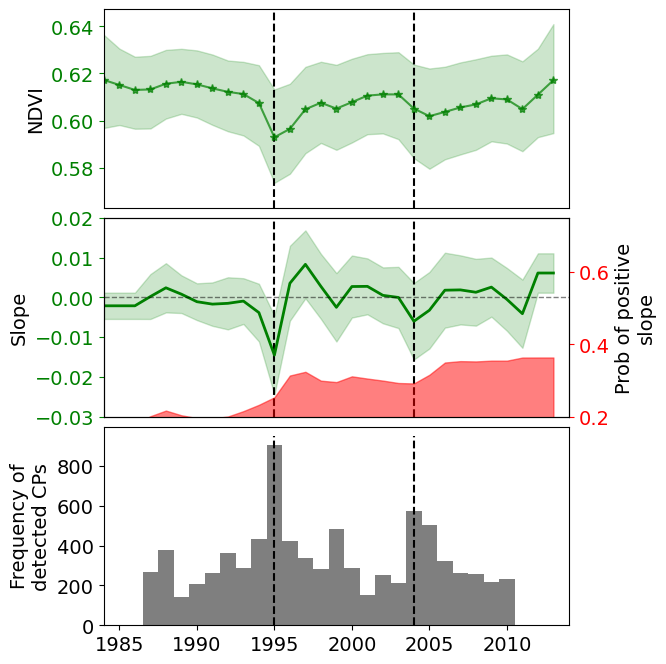

In [10]:
fig, ax = plt.subplots(3,
                       1,
                       figsize=(6, 8),
                       gridspec_kw={
                           "wspace": 0.1,
                           "hspace": 0.05
                       })
ax[0].plot(t, y_ndvi_mean, "-*", color="green", alpha=0.7, label="EF")
ax[0].fill_between(t, ci_ndvi_0_pd, ci_ndvi_1_pd, color="green", alpha=0.2)
ax[0].set_ylabel("NDVI", fontsize=14)
ax[0].tick_params(axis="y", colors="green")
ax[0].tick_params(axis="both", which="major", labelsize=14)
ax[0].set_xticks([])
ax[0].xaxis.set_tick_params(width=0)
ax[0].set_ylim(np.min(y_ndvi_mean) - 0.03, np.max(y_ndvi_mean) + 0.03)
ax[0].set_xlim(1984, 2014)
ax[0].vlines(most_common_years,
             ax[0].get_ylim()[0],
             ax[0].get_ylim()[1],
             color="black",
             linestyle="--")

ax[1].plot(t, slp_ndvi_pd, color="green", linewidth=2, label="slope")
ax[1].fill_between(t,
                   slp_ndvi_pd - slp_ndvi_sd,
                   slp_ndvi_pd + slp_ndvi_sd,
                   color="green",
                   alpha=0.2)
ax[1].set_ylim(-0.03, 0.02)
ax[1].set_xticks([])
ax[1].set_xlim(1984, 2014)
ax[1].set_ylabel("Slope", fontsize=14)
ax[1].tick_params(axis="y", colors="green")
ax[1].vlines(most_common_years,
             ax[1].get_ylim()[0],
             ax[1].get_ylim()[1],
             color="black",
             linestyle="--")
ax[1].axhline(0, color="black", linestyle="--", linewidth=1,alpha=0.5) 
ax02 = ax[1].twinx()
ax02.fill_between(t, 0, slp_pos_mean, color="red", alpha=0.5)
ax02.set_ylim(0.2, 0.75)
ax02.tick_params(axis="y", colors="red")
ax02.set_ylabel("Prob of positive\nslope", fontsize=14)


bin_centers = t[:-1] + np.diff(t) / 2
bin_edges = np.concatenate(
    ([t[0] - (t[1] - t[0]) / 2], bin_centers, [t[-1] + (t[1] - t[0]) / 2]))
ax[2].hist(cp_ndvi, bins=bin_edges, color="black", alpha=0.5)
ax[2].set_ylabel("Frequency of\ndetected CPs", fontsize=14, color="black")
ax[2].set_xlim(1984, 2014)
ax[2].vlines(most_common_years,
             ax[2].get_ylim()[0],
             ax[2].get_ylim()[1],
             color="black",
             linestyle="--")

# Causal Inference
Our goal is to find the impact of 1994 land cover change on NDVI

First apply Rbeast to EF

In [11]:
ef_changed = lc_changed.isel(band=0)
metadata = rb.args(whichDimIsTime=1, season="none", startTime=1984)
prior = rb.args(trendMinSepDist=1)
mcmc = rb.args(seed=1)
extra = rb.args(  # a set of options to specify the outputs or computational configurations
    dumpInputData=
    True,  # make a copy of the aggregated input data in the beast ouput
    numThreadsPerCPU=2,  # Paralell  computing: use 2 threads per cpu core
    numParThreads=
    0,  # `0` means using all CPU cores: total num of ParThreads = numThreadsPerCPU * core Num
    printOptions=False,
    computeTrendSlope=True)
ef_changed_rbeast = rb.beast123(ef_changed.values, metadata, prior, mcmc, extra)
ef_changed_cp = ndvi.isel(time=0).copy(data=ef_changed_rbeast.trend.cp[0, :, :])
ef_changed_cpPr = ndvi.isel(time=0).copy(data=ef_changed_rbeast.trend.cpPr[0, :, :])
ef_changed_cp_sig = ef_changed_cp.where(ef_changed_cpPr > 0.5)


Parallel computing: thread#1  generated ... 
Parallel computing: thread#2  generated ... 
Parallel computing: thread#3  generated ... 
Parallel computing: thread#4  generated ... 
Parallel computing: thread#5  generated ... 
Parallel computing: thread#6  generated ... 
Parallel computing: thread#7  generated ... 
Parallel computing: thread#8  generated ... 
Parallel computing: thread#9  generated ... 
Parallel computing: thread#10 generated ... 
Parallel computing: thread#11 generated ... 
Parallel computing: thread#12 generated ... 
Parallel computing: thread#13 generated ... 
Parallel computing: thread#14 generated ... 
Parallel computing: thread#15 generated ... 
Parallel computing: thread#16 generated ... 
Parallel computing: thread#17 generated ... 
Parallel computing: thread#18 generated ... 
Parallel computing: thread#19 generated ... 
Parallel computing: thread#20 generated ... 
Parallel computing: thread#21 generated ... 
Parallel computing: thread#22 generated ... 
Parallel c

array(8)

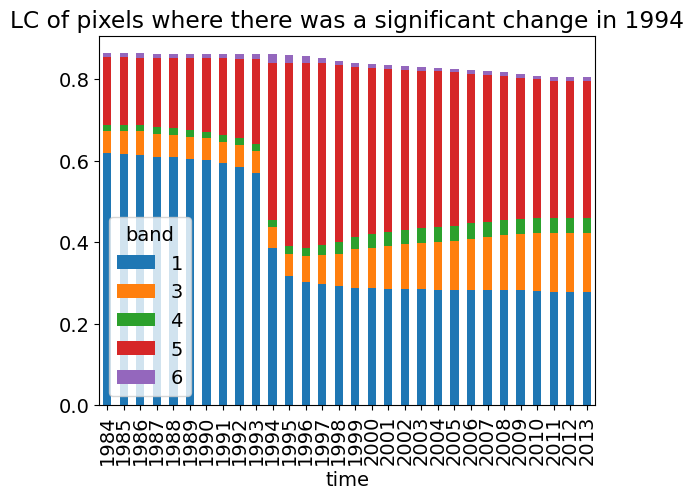

In [14]:
changed_1994 = (ef_changed_cp_sig == 1994)
lc_changed_1994 = lc.where(changed_1994 == True)
lc_changed_1994.mean(["lat", "lon"]).to_pandas().plot(
    kind="bar",
    stacked=True,
    title="LC of pixels where there was a significant change in 1994")
ef_1984_1993 = lc_changed_1994.sel(time=slice("1984", "1993")).isel(band=0)
ef_1984_1993_mean = ef_1984_1993.mean(["time"])
ef_1995_2013 = lc_changed.isel(band=0).sel(time=slice("1995", "2013"))
post_dist_rec = ef_1995_2013 >= (ef_1984_1993_mean)
a = xr.apply_ufunc(year_detect,
                   post_dist_rec,
                   input_core_dims=[["time"]],
                   vectorize=True)
ef_changed_1994 = lc_changed_1994.isel(band=0).stack(
    z=["lat", "lon"]).to_pandas().dropna(axis=1)
# ef_changed_1994.plot(legend=False)
np.isfinite(a.where(a > 5)).sum().values


#--------------------------------------------------#
#      OPTIONS used in the MCMC inference          #
#--------------------------------------------------#
#  Set extra.printOptions=0 to suppress printing   #
#--------------------------------------------------#

#......Start of displaying 'MetaData' ......
  metadata =  rb.args() ### or 'lambda: None': just get an empty object###
  metadata.isRegularOrdered = True
  metadata.season           = 'none'
  metadata.startTime        = 1984.00000
  metadata.deltaTime        = 1.00000
  metadata.whichDimIsTime   = 1
  metadata.missingValue     = float('nan')
  metadata.maxMissingRate   = 0.7500
  metadata.detrend          = False
#........End of displaying MetaData ........

#......Start of displaying 'prior' ......
  prior =  rb.args() ### or 'lambda: None': just get an empty object###
  prior.modelPriorType	  = 1
  prior.trendMinOrder	  = 0
  prior.trendMaxOrder	  = 1
  prior.trendMinKnotNum  = 0
  prior.trendMaxKnotNum  = 9
  prior.tre

(<Figure size 640x480 with 5 Axes>,
 array([<AxesSubplot:xlabel='[]', ylabel='trend'>,
        <AxesSubplot:xlabel='[]', ylabel='Pr(tcp)'>,
        <AxesSubplot:xlabel='[]', ylabel='tOrder'>,
        <AxesSubplot:xlabel='[]', ylabel='slpsgn'>,
        <AxesSubplot:xlabel='time', ylabel='error'>], dtype=object))

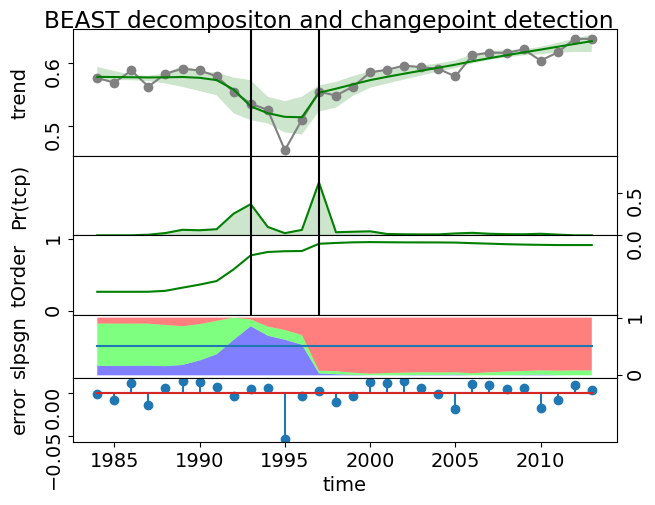

In [15]:
ndvi_changed_1994 = ndvi.where(changed_1994==True)
ndvi_changed_1994_mean = ndvi_changed_1994.mean(["lat","lon"])
ndvi_changed_1994_mean_rbeast = rb.beast(ndvi_changed_1994_mean.values,
                                        season="none",
                                        start=1984,
                                        tseg_minlength=1)
# rb.plot(lai_not_changed_mean_rbeast)
rb.plot(ndvi_changed_1994_mean_rbeast)

Extract ndvi data of pixels that are changed in 1994 and their surronding unchanged pixels

In [16]:
# Get the indices of pixels within 50 km radius
ndvi_changed_stacked = ndvi_changed_1994.stack(z=["lon", "lat"])
ndvi_not_changed_stacked = ndvi_not_changed.stack(z=["lon", "lat"])
# select a random year and calculate the distances within 50 km radius and get all indices
changed_year_ndvi = ndvi_changed_stacked.isel(time=10)
df = changed_year_ndvi.to_dataframe()
coords = np.radians(df[["lat", "lon"]])
dist = DistanceMetric.get_metric("haversine")
tree = BallTree(coords, metric=dist)
indices = tree.query_radius(coords, r=0.005)


data_ndvi = []
arr_idx = []
# lc_changed_1994_diff_net_data = []
n = len(indices)
for k in tqdm(range(n)):
    # for k in tqdm(np.arange(457635, 457640)):
    data = []
    idx = indices[k]
    # Get the changed NDVI values of the centeral pixel
    center_pixel = idx[np.where(idx == k)]
    center_pixel_ndvi = ndvi_changed_stacked[:, center_pixel].values.squeeze()

    # continue if the central pixel is nan
    # if np.isnan(center_pixel_ndvi).all():
    #     continue
    if np.isnan(center_pixel_ndvi).sum()>5:
        continue

    data.append(center_pixel_ndvi)

    # Go over the neighboring pixels and get the NDVI values of unchanged pixels
    for i in range(len(idx)):
        if idx[i] == center_pixel:
            continue
        tmp = ndvi_not_changed_stacked[:, idx[i]].values.squeeze()
        # skip if the neighboring pixel is all nans
        # if np.isnan(tmp).all():
        #     continue
        if np.isnan(tmp).sum()>5:
            continue
        data.append(tmp)
    data_ndvi.append(np.array(data).transpose())
    arr_idx.append(k)  # Get the index of changed pixel
    # lc_changed_1994_diff_net_data.append(lc_changed_1994_diff_net_stacked[k].values)
with open("../../working/ndvi_1994_data", "wb") as fp:
    pickle.dump(data_ndvi, fp)
with open("../../working/arr_idx_1994", "wb") as fp:
    pickle.dump(arr_idx, fp)

/data/home/hamiddashti/miniconda3/envs/geo/lib/python3.9/site-packages/sklearn/neighbors/_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
  4%|▍         | 25346/603904 [00:09<03:47, 2542.20it/s]


KeyboardInterrupt: 

Get the mean of all changed and not changed for impact analyses

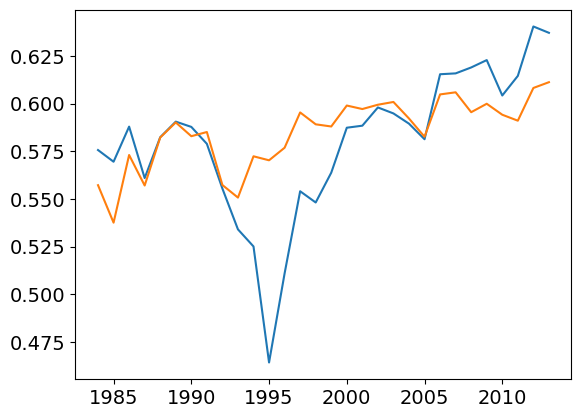

In [28]:
initial_array = np.array(data_ndvi[0])[:, 1:]
# for k in range(len(data_lai)):
for k in np.arange(1, len(data_ndvi)):
    tmp1 = np.array(data_ndvi[k])[:, 1:]
    if k == 1:
        all_data_not_changed = np.concatenate([initial_array, tmp1], axis=1)
        continue
    all_data_not_changed = np.concatenate([all_data_not_changed, tmp1], axis=1)

ndvi_not_changed_1994 = np.nanmean(all_data_not_changed, axis=1)
ndvi_changed_mean_1994 = np.array([ndvi_changed_1994_mean.values, ndvi_not_changed_1994]).transpose()
plt.plot(t,ndvi_changed_mean_1994)
with open("../../working/ndvi_changed_mean_1994", "wb") as fp:
    pickle.dump(X, fp)

In [ ]:
net_change_mean_rbeast = rb.beast(net_change.mean(["lat", "lon"]).values,
                                  season="none",
                                  start=1985,
                                  tseg_minlength=1)
rb.plot(net_change_mean_rbeast)

In [ ]:
metadata = rb.args(whichDimIsTime=1, season="none", startTime=1985)
prior = rb.args(trendMinSepDist=1)
mcmc = rb.args(seed=1)
extra = rb.args(  # a set of options to specify the outputs or computational configurations
    dumpInputData=
    True,  # make a copy of the aggregated input data in the beast ouput
    numThreadsPerCPU=2,  # Paralell  computing: use 2 threads per cpu core
    numParThreads=
    0,  # `0` means using all CPU cores: total num of ParThreads = numThreadsPerCPU * core Num
    printOptions=False,
    computeTrendSlope=True)
net_changed_rbeast = rb.beast123(net_change.values, metadata, prior, mcmc,
                                 extra)


In [ ]:
net_changed_cp = repo.copy(data=net_changed_rbeast.trend.cp[0, :, :])
net_changed_cpPr = repo.copy(data=net_changed_rbeast.trend.cpPr[0, :, :])
net_changed_cp_sig = net_changed_cp.where(ef_changed_cpPr > 0.5)

In [ ]:
avs = []
sums = []
for year in np.arange(1985, 2014):

    net_change_cp = net_change.sel(time=year).where(net_changed_cp_sig == year)
    avs.append(net_change_cp.mean().values)
    sums.append((net_changed_cp_sig == year).sum().values)


Now lets work on NDVI


In [ ]:
ndvi_changed = ndvi.where(changed == True)
ndvi_not_changed = ndvi.where(not_changed == True)
I = (np.isfinite(ndvi_changed).sum(dim="time") > 25)
ndvi_ok = ndvi_changed.where(I == True)
ndvi_changed_mean = ndvi_changed.mean(["lat", "lon"])
ndvi_region_mean_rbeast = rb.beast(ndvi_changed_mean.values,
                                   season="none",
                                   start=1984,
                                   tseg_minlength=1,
                                   detrend=True)

rb.plot(ndvi_region_mean_rbeast)
# tmp.append(ndvi_region_mean_rbeast.marg_lik)

In [ ]:
metadata = rb.args(whichDimIsTime=1, season="none", startTime=1984)
prior = rb.args(trendMinSepDist=1)
mcmc = rb.args(seed=1)
extra = rb.args(  # a set of options to specify the outputs or computational configurations
    dumpInputData=
    True,  # make a copy of the aggregated input data in the beast ouput
    numThreadsPerCPU=2,  # Paralell  computing: use 2 threads per cpu core
    numParThreads=
    0,  # `0` means using all CPU cores: total num of ParThreads = numThreadsPerCPU * core Num
    printOptions=False,
    computeTrendSlope=True)
ndvi_changed_rbeast = rb.beast123(
    ndvi_changed.round(2).values, metadata, prior, mcmc, extra)
Y = ndvi_changed_rbeast.trend.Y.reshape(30, -1)
Y_ok = Y[:, np.isfinite(Y).all(0)]
plt.plot(t, np.mean(Y_ok, 1))
plt.scatter(t, np.mean(Y_ok, 1))


In [ ]:
ndvi_changed_cp = repo.copy(data=ndvi_changed_rbeast.trend.cp[0, :, :])
ndvi_changed_cpPr = repo.copy(data=ndvi_changed_rbeast.trend.cpPr[0, :, :])
ndvi_changed_cp_sig = ndvi_changed_cp.where(ndvi_changed_cpPr > 0.5)
ndvi_changed_cp_sig.plot.hist(bins=np.arange(1984, 2014))
tmp = ndvi_changed_cp_sig.where(ef_changed_cp_sig == 1995)
tmp.plot.hist(bins=np.arange(1984, 2014))


In [ ]:
lai_changed = lai4g.where(changed == True)
lai_not_changed = lai4g.where(not_changed == True)
I = (np.isfinite(lai_changed).sum(dim="time") > 25)
lai_ok = lai_changed.where(I == True)
lai_changed_mean = lai_changed.mean(["lat", "lon"])
lai_region_mean_rbeast = rb.beast(lai_changed_mean.values,
                                  season="none",
                                  start=1984,
                                  tseg_minlength=1,
                                  detrend=True)

rb.plot(lai_region_mean_rbeast)

In [ ]:
metadata = rb.args(whichDimIsTime=1, season="none", startTime=1984)
prior = rb.args(trendMinSepDist=1)
mcmc = rb.args(seed=1)
extra = rb.args(  # a set of options to specify the outputs or computational configurations
    dumpInputData=
    True,  # make a copy of the aggregated input data in the beast ouput
    numThreadsPerCPU=2,  # Paralell  computing: use 2 threads per cpu core
    numParThreads=
    0,  # `0` means using all CPU cores: total num of ParThreads = numThreadsPerCPU * core Num
    printOptions=False,
    computeTrendSlope=True)
lai_changed_rbeast = rb.beast123(
    lai_changed.round(2).values, metadata, prior, mcmc, extra)


In [ ]:
Y = lai_changed_rbeast.trend.Y.reshape(30, -1)
Y_ok = Y[:, np.isfinite(Y).all(0)]
plt.plot(t, np.mean(Y_ok, 1))
plt.scatter(t, np.mean(Y_ok, 1))


In [ ]:
metadata = rb.args(whichDimIsTime=1, season="none", startTime=1984)
prior = rb.args(trendMinSepDist=1)
mcmc = rb.args(seed=1)
extra = rb.args(  # a set of options to specify the outputs or computational configurations
    dumpInputData=
    True,  # make a copy of the aggregated input data in the beast ouput
    numThreadsPerCPU=2,  # Paralell  computing: use 2 threads per cpu core
    numParThreads=
    0,  # `0` means using all CPU cores: total num of ParThreads = numThreadsPerCPU * core Num
    printOptions=False,
    computeTrendSlope=True)
ndvi_rbeast = rb.beast123(ndvi.values, metadata, prior, mcmc, extra)
Y = ndvi_rbeast.trend.Y.reshape(30, -1)
Y_ok = Y[:, np.isfinite(Y).all(0)]
plt.plot(t, np.mean(Y_ok, 1))


In [ ]:
metadata = rb.args(whichDimIsTime=1, season="none", startTime=1984)
prior = rb.args(trendMinSepDist=1)
mcmc = rb.args(seed=1)
extra = rb.args(  # a set of options to specify the outputs or computational configurations
    dumpInputData=
    True,  # make a copy of the aggregated input data in the beast ouput
    numThreadsPerCPU=2,  # Paralell  computing: use 2 threads per cpu core
    numParThreads=
    0,  # `0` means using all CPU cores: total num of ParThreads = numThreadsPerCPU * core Num
    printOptions=False,
    computeTrendSlope=True)
ndvi_not_changed_rbeast = rb.beast123(
    ndvi_not_changed.round(2).values, metadata, prior, mcmc, extra)
Y = ndvi_not_changed_rbeast.trend.Y.reshape(30, -1)
Y_ok = Y[:, np.isfinite(Y).all(0)]
plt.plot(t, np.mean(Y_ok, 1))


### Causal inference for the entire region


In [ ]:
changed_1994 = (ef_changed_cp_sig == 1994)
lc_changed_1994 = lc.where(changed_1994 == True)
lc_changed_1994.mean(["lat", "lon"]).to_pandas().plot(
    kind="bar",
    stacked=True,
    title="LC of pixels where there was a significant change in 1994")
ef_1984_1993 = lc_changed_1994.sel(time=slice("1984", "1993")).isel(band=0)
ef_1984_1993_mean = ef_1984_1993.mean(["time"])
ef_1995_2013 = lc_changed.isel(band=0).sel(time=slice("1995", "2013"))
post_dist_rec = ef_1995_2013 >= (ef_1984_1993_mean)
a = xr.apply_ufunc(year_detect,
                   post_dist_rec,
                   input_core_dims=[["time"]],
                   vectorize=True)
ef_changed_1994 = lc_changed_1994.isel(band=0).stack(
    z=["lat", "lon"]).to_pandas().dropna(axis=1)
ef_changed_1994.plot(legend=False)
np.isfinite(a.where(a > 5)).sum()


In [ ]:
ndvi_changed_1994 = ndvi.where(changed_1994 == True)
ndvi_changed_1994_mean = ndvi_changed_1994.mean(["lat", "lon"])
ndvi_changed_1994_mean_rbeast = rb.beast(ndvi_changed_1994_mean.values,
                                         season="none",
                                         start=1984,
                                         tseg_minlength=1)
# rb.plot(lai_not_changed_mean_rbeast)
rb.plot(ndvi_changed_1994_mean_rbeast)

In [ ]:
metadata = rb.args(whichDimIsTime=1, season="none", startTime=1984)
prior = rb.args(trendMinSepDist=1)
mcmc = rb.args(seed=1)
extra = rb.args(  # a set of options to specify the outputs or computational configurations
    dumpInputData=
    True,  # make a copy of the aggregated input data in the beast ouput
    numThreadsPerCPU=2,  # Paralell  computing: use 2 threads per cpu core
    numParThreads=
    0,  # `0` means using all CPU cores: total num of ParThreads = numThreadsPerCPU * core Num
    printOptions=False,
    computeTrendSlope=True)
ndvi_changed_1994_rbeast = rb.beast123(
    ndvi_changed_1994.round(2).values, metadata, prior, mcmc, extra)
Y_tmp = lai.copy(data=ndvi_changed_1994_rbeast.trend.Y)
Y_tmp.mean(["lat", "lon"]).plot()


In [ ]:
y_1993 = Y_tmp.sel(time="1993").squeeze()
y_1994 = Y_tmp.sel(time="1994").squeeze()
y_1999 = Y_tmp.sel(time="1999").squeeze()
dndvi_regrowth = (y_1999 - y_1994)
dndvi_regrowth.plot.hist()

In [ ]:
dndvi_disturb = y_1993 - y_1994
dndvi_disturb.plot.hist()

In [ ]:
pre_dist_mean = Y_tmp.sel(time=slice("1984", "1993")).mean("time")
post_dist = Y_tmp.sel(time=slice("1995", "2013"))
post_dist_rec = post_dist >= (pre_dist_mean)


In [ ]:
def year_detect(x):
    if (x == False).all():
        return np.nan
    idx = next((i for i, j in enumerate(x) if j), None)
    return idx


a = xr.apply_ufunc(year_detect,
                   post_dist_rec,
                   input_core_dims=[["time"]],
                   vectorize=True)


In [ ]:
print("time to recover: " + str((a + 1).mean().values))


In [ ]:
Y_1994 = ndvi_changed_1994_rbeast.trend.Y.reshape(30, -1)
Y_ok = Y[:, np.isfinite(Y).all(0)]
plt.plot(t, np.mean(Y_1994, 1))


In [ ]:
ndvi_changed_stacked = ndvi_changed_1994.stack(z=["lon", "lat"])
ndvi_not_changed_stacked = ndvi_not_changed.stack(z=["lon", "lat"])
# select a random year and calculate the distances within 50 km radius and get all indices
changed_year_ndvi = ndvi_changed_stacked.isel(time=10)
df = changed_year_ndvi.to_dataframe()
coords = np.radians(df[["lat", "lon"]])
dist = DistanceMetric.get_metric("haversine")
tree = BallTree(coords, metric=dist)
indices = tree.query_radius(coords, r=0.005)

In [ ]:
lai_changed_1994 = lai4g.where(changed_1994 == True)
lai_changed_1994_mean = lai_changed_1994.mean(["lat", "lon"])
lai_changed_1994_mean_rbeast = rb.beast(lai_changed_1994_mean.values,
                                        season="none",
                                        start=1984,
                                        tseg_minlength=1)
# rb.plot(lai_not_changed_mean_rbeast)
rb.plot(lai_changed_1994_mean_rbeast)

In [ ]:
metadata = rb.args(whichDimIsTime=1, season="none", startTime=1984)
prior = rb.args(trendMinSepDist=1)
mcmc = rb.args(seed=1)
extra = rb.args(  # a set of options to specify the outputs or computational configurations
    dumpInputData=
    True,  # make a copy of the aggregated input data in the beast ouput
    numThreadsPerCPU=2,  # Paralell  computing: use 2 threads per cpu core
    numParThreads=
    0,  # `0` means using all CPU cores: total num of ParThreads = numThreadsPerCPU * core Num
    printOptions=False,
    computeTrendSlope=True)
lai_changed_1994_rbeast = rb.beast123(
    lai_changed_1994.round(2).values, metadata, prior, mcmc, extra)
Y_tmp = lai.copy(data=lai_changed_1994_rbeast.trend.Y)
Y_tmp.mean(["lat", "lon"]).plot()


In [ ]:
data_ndvi = []
arr_idx = []
# lc_changed_1994_diff_net_data = []
n = len(indices)
for k in tqdm(range(n)):
    # for k in tqdm(np.arange(457635, 457640)):
    data = []
    idx = indices[k]
    # Get the changed NDVI values of the centeral pixel
    center_pixel = idx[np.where(idx == k)]
    center_pixel_ndvi = ndvi_changed_stacked[:, center_pixel].values.squeeze()

    # continue if the central pixel is nan
    # if np.isnan(center_pixel_ndvi).all():
    #     continue
    if np.isnan(center_pixel_ndvi).sum() > 5:
        continue

    data.append(center_pixel_ndvi)

    # Go over the neighboring pixels and get the NDVI values of unchanged pixels
    for i in range(len(idx)):
        if idx[i] == center_pixel:
            continue
        tmp = ndvi_not_changed_stacked[:, idx[i]].values.squeeze()
        # skip if the neighboring pixel is all nans
        # if np.isnan(tmp).all():
        #     continue
        if np.isnan(tmp).sum() > 5:
            continue
        data.append(tmp)
    data_ndvi.append(np.array(data).transpose())
    arr_idx.append(k)  # Get the index of changed pixel
    # lc_changed_1994_diff_net_data.append(lc_changed_1994_diff_net_stacked[k].values)

In [ ]:
with open("../../working/ndvi_1994_data", "wb") as fp:
    pickle.dump(data_ndvi, fp)
with open("../../working/arr_idx_1994", "wb") as fp:
    pickle.dump(arr_idx, fp)

In [ ]:
ndvi_changed_1994_mean = ndvi_changed_1994.mean(["lat", "lon"])

In [ ]:
initial_array = np.array(data_ndvi[0])[:, 1:]
# for k in range(len(data_lai)):
for k in np.arange(1, len(data_ndvi)):
    tmp1 = np.array(data_ndvi[k])[:, 1:]
    if k == 1:
        all_data_not_changed = np.concatenate([initial_array, tmp1], axis=1)
        continue
    all_data_not_changed = np.concatenate([all_data_not_changed, tmp1], axis=1)


In [ ]:
ndvi_not_changed_1994 = np.nanmean(all_data_not_changed, axis=1)

In [ ]:
X = np.array([ndvi_changed_1994_mean.values,
              ndvi_not_changed_1994]).transpose()
plt.plot(t, X)


In [ ]:
with open("../../working/ndvi_changed_mean_1994", "wb") as fp:
    pickle.dump(X, fp)

In [ ]:
t2 = pd.date_range(start=pd.datetime(1984, 1, 1),
                   periods=X.shape[0],
                   freq="AS-JUL")
df_tmp = pd.DataFrame(data=X, index=t2)
pre_priod = ["19840701", "19930701"]
post_priod = ["19940701", "20130701"]
ci = CausalImpact(
    df_tmp,
    pre_priod,
    post_priod,
    model_args={
        "fit_method": "hmc",
        "standardize": True,
        # "prior_level_sd": 0.1,
    },
)
print(ci.summary())
ci.plot()

In [ ]:
import random

data = pd.read_pickle("../../working/ndvi_1994_data")
t2 = pd.date_range(start=pd.datetime(1984, 1, 1), periods=30, freq="AS-JUL")
# for k in range(len(data_ndvi)):
k = 0
m = data[k]
mask = np.isnan(m)
m[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), m[~mask])
df_tmp = pd.DataFrame(data=m, index=t2)
pre_priod = ["19840701", "19930701"]
post_priod = ["19940701", "20130701"]
random.seed(2)
ci = CausalImpact(
    df_tmp,
    pre_priod,
    post_priod,
    model_args={
        "fit_method": "hmc",
        "standardize": True,
        # "prior_level_sd": None,
    },
)
print(ci.summary())


In [ ]:
m = data_ndvi[0]
imp = IterativeImputer(random_state=0)
imp.fit(m)
X = imp.transform(m)
df_tmp = pd.DataFrame(data=X, index=t2)
pre_priod = ["19840701", "19930701"]
post_priod = ["19940701", "20130701"]
random.seed(2)
ci = CausalImpact(
    df_tmp,
    pre_priod,
    post_priod,
    model_args={
        "fit_method": "hmc",
        "standardize": True,
        # "prior_level_sd": None,
    },
)

In [ ]:
print(ci.summary())
ci.plot()

In [ ]:
import random
import asyncio


def background(f):

    def wrapped(*args, **kwargs):
        return asyncio.get_event_loop().run_in_executor(
            None, f, *args, **kwargs)

    return wrapped


@background
def causal_inference(k, t2, data, res):
    print("-----------------------------------\n")
    print("Pixel number:" + str(k))
    print("-----------------------------------\n")

    m = data[k]
    imp = IterativeImputer(random_state=0)
    imp.fit(m)
    X = imp.transform(m)
    df_tmp = pd.DataFrame(data=X, index=t2)
    pre_priod = ["19840701", "19930701"]
    post_priod = ["19940701", "20130701"]
    random.seed(2)
    ci = CausalImpact(
        df_tmp,
        pre_priod,
        post_priod,
        model_args={
            "fit_method": "hmc",
            "standardize": True,
            # "prior_level_sd": None,
        },
    )
    outs = [
        ci.p_value,
        ci.summary_data.loc["actual"]["average"],
        ci.summary_data.loc["predicted"]["average"],
        ci.summary_data.loc["abs_effect"]["average"],
        ci.summary_data.loc["rel_effect"]["average"],
        ci.summary_data.loc["actual"]["cumulative"],
        ci.summary_data.loc["predicted"]["cumulative"],
        ci.summary_data.loc["abs_effect"]["cumulative"],
        ci.summary_data.loc["rel_effect"]["cumulative"],
    ]
    res.append(outs)
    return res
    # except:
    #     outs = [np.repeat(np.nan, 9)]
    #     res.append(outs)
    #     return res

In [ ]:
res = []
for i in range(len(data_ndvi)):
    causal_inference(i, t2, data_ndvi, res)


In [ ]:
res

In [ ]:
len(data_ndvi)

In [ ]:
        a = [
            ci.p_value,
            ci.summary_data.loc["actual"]["average"],
            ci.summary_data.loc["predicted"]["average"],
            ci.summary_data.loc["abs_effect"]["average"],
            ci.summary_data.loc["rel_effect"]["average"],
            ci.summary_data.loc["actual"]["cumulative"],
            ci.summary_data.loc["predicted"]["cumulative"],
            ci.summary_data.loc["abs_effect"]["cumulative"],
            ci.summary_data.loc["rel_effect"]["cumulative"],
        ]

In [ ]:
len(res)

In [ ]:
pre_priod = ["19840701", "19930701"]
post_priod = ["19940701", "20130701"]
k = 250
m = data_ndvi[k]
# imp = IterativeImputer(random_state=0)
# imp.fit(m)
# X = imp.transform(m)
df_tmp = pd.DataFrame(data=m, index=t2)
df_tmp.iloc[:, 0].plot()


In [ ]:
data_ndvi[250].shape

In [ ]:
ci = CausalImpact(
    df_tmp,
    pre_priod,
    post_priod,
    model_args={
        "fit_method": "hmc",
        "standardize": True,
        # "prior_level_sd": 0.1,
    },
)
print(ci.summary())
ci.plot()


In [ ]:
print(ci.summary())

In [ ]:
X = np.array([ndvi_changed_1994_mean.values,
              ndvi_not_changed_mean.values]).transpose()
plt.plot(t, X)


In [ ]:
t2 = pd.date_range(start=pd.datetime(1984, 1, 1),
                   periods=X.shape[0],
                   freq="AS-JUL")
df_tmp = pd.DataFrame(data=X, index=t2)
df_tmp

In [ ]:
pre_priod = ["19840701", "20040701"]
post_priod = ["20050701", "20130701"]
ci = CausalImpact(
    df_tmp,
    pre_priod,
    post_priod,
    model_args={
        "fit_method": "hmc",
        "standardize": True,
        "prior_level_sd": 0.1,
    },
)
print(ci.summary())
ci.plot()

In [ ]:
I = np.isfinite(ndvi).all(dim="time")
ndvi_ok = ndvi.where(I == True)


In [ ]:
out1 = rb.beast(ndvi.mean(["lat", "lon"]).values,
                season="none",
                start=1984,
                tseg_minlength=1,
                detrend=True)
# out2 = rb.beast(lai.mean(["lat","lon"]).values,
#                                  season="none",
#                                  start=1984,
#                                  tseg_minlength=3)
# out3 = rb.beast(lai4g.mean(["lat","lon"]).values,
#                                  season="none",
#                                  start=1984,
#                                  tseg_minlength=3)
print(out1.marg_lik)
# rb.plot(out1)
# rb.plot(out2)
# rb.plot(out3)

### Apply Rbeast on landcover classes


In [ ]:
# Only EF, shrub and DF. Changes in other classes are not that substantial
ef_region_mean = percent.isel(band=0).mean(["lat", "lon"])  # Evergreen forest
sh_region_mean = percent.isel(band=2).mean(["lat", "lon"])  # shrub
hb_region_mean = percent.isel(band=3).mean(["lat", "lon"])  # herb
sparse_region_mean = percent.isel(band=4).mean(["lat", "lon"])  # herb
barren_region_mean = percent.isel(band=5).mean(["lat", "lon"])  # herb

ef_region_mean_rbeast = rb.beast(ef_region_mean.values,
                                 season="none",
                                 start=1984,
                                 tseg_minlength=3)
sh_region_mean_rbeast = rb.beast(sh_region_mean.values,
                                 season="none",
                                 start=1984,
                                 tseg_minlength=3)
hb_region_mean_rbeast = rb.beast(hb_region_mean.values,
                                 season="none",
                                 start=1984,
                                 tseg_minlength=3)
sparse_region_mean_rbeast = rb.beast(sparse_region_mean.values,
                                     season="none",
                                     start=1984,
                                     tseg_minlength=3)
barren_region_mean_rbeast = rb.beast(barren_region_mean.values,
                                     season="none",
                                     start=1984,
                                     tseg_minlength=3)


In [ ]:
rb.plot(ef_region_mean_rbeast)

### Apply Rbeast on regional mean of LAI


In [ ]:
lai_region_mean = lai.mean(["lat", "lon"])
lai_region_mean_rbeast = rb.beast(lai_region_mean.values,
                                  season="none",
                                  start=1984,
                                  tseg_minlength=3)
rb.plot(lai_region_mean_rbeast)

In [ ]:
temp_region_mean = temp.mean(["lat", "lon"])
temp_region_mean_rbeast = rb.beast(temp_region_mean.values,
                                   season="none",
                                   start=1984,
                                   tseg_minlength=3)
rb.plot(temp_region_mean_rbeast)
print([
    temp_region_mean_rbeast.trend.cp[0], temp_region_mean_rbeast.trend.cpPr[0]
])


In [ ]:
d2m_region_mean = d2m.mean(["lat", "lon"])
d2m_region_mean_rbeast = rb.beast(d2m_region_mean.values,
                                  season="none",
                                  start=1984,
                                  tseg_minlength=3)
rb.plot(d2m_region_mean_rbeast)
print(
    [d2m_region_mean_rbeast.trend.cp[0], d2m_region_mean_rbeast.trend.cpPr[0]])


In [ ]:
ssr_region_mean = ssr.mean(["lat", "lon"])
ssr_region_mean_rbeast = rb.beast(ssr_region_mean.values,
                                  season="none",
                                  start=1984,
                                  tseg_minlength=3)
rb.plot(ssr_region_mean_rbeast)
print(
    [ssr_region_mean_rbeast.trend.cp[0], ssr_region_mean_rbeast.trend.cpPr[0]])


In [ ]:
sw_region_mean = sw.mean(["lat", "lon"])
sw_region_mean_rbeast = rb.beast(sw_region_mean.values,
                                 season="none",
                                 start=1984,
                                 tseg_minlength=3)
rb.plot(sw_region_mean_rbeast)
print([sw_region_mean_rbeast.trend.cp[0], sw_region_mean_rbeast.trend.cpPr[0]])


In [ ]:
tp_region_mean = tp.mean(["lat", "lon"])
tp_region_mean_rbeast = rb.beast(tp_region_mean.values,
                                 season="none",
                                 start=1984,
                                 tseg_minlength=3)
rb.plot(tp_region_mean_rbeast)
print([tp_region_mean_rbeast.trend.cp[0], tp_region_mean_rbeast.trend.cpPr[0]])


### Apply Rbeast on all pixels of LAI and environemntal variables


In [ ]:
metadata = rb.args(whichDimIsTime=1, season="none", startTime=1984)
prior = rb.args(trendMinSepDist=3, trendMaxKnotNum=4)
mcmc = rb.args(seed=1)
extra = rb.args(  # a set of options to specify the outputs or computational configurations
    dumpInputData=
    True,  # make a copy of the aggregated input data in the beast ouput
    numThreadsPerCPU=2,  # Paralell  computing: use 2 threads per cpu core
    numParThreads=
    0,  # `0` means using all CPU cores: total num of ParThreads = numThreadsPerCPU * core Num
    printOptions=False,
    computeTrendSlope=True)
season = "none"
lai_rbeast = rb.beast123(lai.values, metadata, prior, mcmc, extra)

In [ ]:
metadata = rb.args(whichDimIsTime=1, season="none", startTime=1984)
prior = rb.args(trendMinSepDist=3, trendMaxKnotNum=4)
mcmc = rb.args(seed=1)
extra = rb.args(  # a set of options to specify the outputs or computational configurations
    dumpInputData=
    True,  # make a copy of the aggregated input data in the beast ouput
    numThreadsPerCPU=2,  # Paralell  computing: use 2 threads per cpu core
    numParThreads=
    0,  # `0` means using all CPU cores: total num of ParThreads = numThreadsPerCPU * core Num
    printOptions=False,
    computeTrendSlope=True)
season = "none"
temp_rbeast = rb.beast123(temp.values, metadata, prior, mcmc, extra)

In [ ]:
metadata = rb.args(whichDimIsTime=1, season="none", startTime=1984)
prior = rb.args(trendMinSepDist=3, trendMaxKnotNum=4)
mcmc = rb.args(seed=1)
extra = rb.args(  # a set of options to specify the outputs or computational configurations
    dumpInputData=
    True,  # make a copy of the aggregated input data in the beast ouput
    numThreadsPerCPU=2,  # Paralell  computing: use 2 threads per cpu core
    numParThreads=
    0,  # `0` means using all CPU cores: total num of ParThreads = numThreadsPerCPU * core Num
    printOptions=False,
    computeTrendSlope=True)
season = "none"
d2m_rbeast = rb.beast123(d2m.values, metadata, prior, mcmc, extra)

In [ ]:
metadata = rb.args(whichDimIsTime=1, season="none", startTime=1984)
prior = rb.args(trendMinSepDist=3, trendMaxKnotNum=4)
mcmc = rb.args(seed=1)
extra = rb.args(  # a set of options to specify the outputs or computational configurations
    dumpInputData=
    True,  # make a copy of the aggregated input data in the beast ouput
    numThreadsPerCPU=2,  # Paralell  computing: use 2 threads per cpu core
    numParThreads=
    0,  # `0` means using all CPU cores: total num of ParThreads = numThreadsPerCPU * core Num
    printOptions=False,
    computeTrendSlope=True)
season = "none"
ssr_rbeast = rb.beast123(ssr.values, metadata, prior, mcmc, extra)

In [ ]:
metadata = rb.args(whichDimIsTime=1, season="none", startTime=1984)
prior = rb.args(trendMinSepDist=3, trendMaxKnotNum=4)
mcmc = rb.args(seed=1)
extra = rb.args(  # a set of options to specify the outputs or computational configurations
    dumpInputData=
    True,  # make a copy of the aggregated input data in the beast ouput
    numThreadsPerCPU=2,  # Paralell  computing: use 2 threads per cpu core
    numParThreads=
    0,  # `0` means using all CPU cores: total num of ParThreads = numThreadsPerCPU * core Num
    printOptions=False,
    computeTrendSlope=True)
season = "none"
sw_rbeast = rb.beast123(sw.values, metadata, prior, mcmc, extra)

In [ ]:
metadata = rb.args(whichDimIsTime=1, season="none", startTime=1984)
prior = rb.args(trendMinSepDist=3, trendMaxKnotNum=4)
mcmc = rb.args(seed=1)
extra = rb.args(  # a set of options to specify the outputs or computational configurations
    dumpInputData=
    True,  # make a copy of the aggregated input data in the beast ouput
    numThreadsPerCPU=2,  # Paralell  computing: use 2 threads per cpu core
    numParThreads=
    0,  # `0` means using all CPU cores: total num of ParThreads = numThreadsPerCPU * core Num
    printOptions=False,
    computeTrendSlope=True)
season = "none"
tp_rbeast = rb.beast123(tp.values, metadata, prior, mcmc, extra)

### Find changed pixels:

Pixels when at least once in a time period there was a change in LC more than 2%


In [ ]:
# stable pixels where classes has not changed more than 2%
# lc_diff = lc.diff("time")
# changed = (abs(lc_diff) >= 0.1).any(dim=["time", "band"])
# not_changed = (abs(lc_diff) < 0.1).all(dim=["time", "band"])
# lc_changed = lc.where(changed==True)

In [ ]:
lc_diff = lc.diff("time")
net_change = lc_diff.where(lc_diff > 0.0).sum("band")
changed = (net_change >= 0.05).any(dim="time")
not_changed = (net_change < 0.05).all(dim="time")
lc_changed = lc.where(changed == True)
lc_not_changed = lc.where(not_changed == True)
lc_changed.mean(["lat", "lon"]).to_pandas().plot(kind="bar",
                                                 stacked=True,
                                                 title="LC changed")
lc_not_changed.mean(["lat", "lon"]).to_pandas().plot(kind="bar",
                                                     stacked=True,
                                                     title="LC Not changed")


In [ ]:
ndvi_changed = ndvi.where(changed == True)
ndvi_not_changed = ndvi.where(not_changed == True)
lai4g_changed = lai4g.where(changed == True)
lai4g_not_changed = lai4g.where(not_changed == True)


In [ ]:
ndvi_changed_mean = ndvi_changed.mean(["lat", "lon"])
ndvi_not_changed_mean = ndvi_not_changed.mean(["lat", "lon"])

ndvi_changed_mean_rbeast = rb.beast(ndvi_changed_mean.values,
                                    season="none",
                                    start=1984,
                                    tseg_minlength=3)
ndvi_not_changed_mean_rbeast = rb.beast(ndvi_not_changed_mean.values,
                                        season="none",
                                        start=1984,
                                        tseg_minlength=3)
rb.plot(ndvi_changed_mean_rbeast)
rb.plot(ndvi_not_changed_mean_rbeast)

In [ ]:
I1, I2 = np.argwhere(arr.values == 423153)[0]
percent[:, :, I1, I2].squeeze().to_pandas().plot(kind="bar", stacked=True)


In [ ]:
ndvi_changed[:, I1, I2]


In [ ]:
ndvi_changed[:, I1, I2]
out = rb.beast(ndvi[:, I1, I2].values,
               season="none",
               start=1984,
               tseg_minlength=3)
rb.plot(out)

In [ ]:
out = rb.beast(lai4g_changed[:, I1, I2].values,
               season="none",
               start=1984,
               tseg_minlength=3)
rb.plot(out)

In [ ]:
out = rb.beast(lai_changed[:, I1, I2].values,
               season="none",
               start=1984,
               tseg_minlength=3)
rb.plot(out)

Apply LAI to changed and not changed seperately


In [ ]:
lai_changed = lai.where(changed == True)
lai_not_changed = lai.where(not_changed == True)

temp_changed = temp.where(changed == True)
temp_not_changed = temp.where(not_changed == True)

temp_changed = temp.where(changed == True)
temp_not_changed = temp.where(not_changed == True)

d2m_changed = d2m.where(changed == True)
d2m_not_changed = d2m.where(not_changed == True)

ssr_changed = ssr.where(changed == True)
ssr_not_changed = ssr.where(not_changed == True)

sw_changed = sw.where(changed == True)
sw_not_changed = sw.where(not_changed == True)

tp_changed = tp.where(changed == True)
tp_not_changed = tp.where(not_changed == True)

vpd_changed = vpd.where(changed == True)
vpd_not_changed = vpd.where(not_changed == True)

co2_changed = co2.where(changed == True)
co2_not_changed = co2.where(not_changed == True)


In [ ]:
vpd_region_mean = vpd.mean(["lat", "lon"])
vpd_region_mean_rbeast = rb.beast(vpd_region_mean.values,
                                  season="none",
                                  start=1984,
                                  tseg_minlength=3)
rb.plot(vpd_region_mean_rbeast)

In [ ]:
lai_changed_mean = lai_changed.mean(["lat", "lon"])
lai_not_changed_mean = lai_not_changed.mean(["lat", "lon"])

lai_changed_mean_rbeast = rb.beast(lai_changed_mean.values,
                                   season="none",
                                   start=1984,
                                   tseg_minlength=3)
lai_not_changed_mean_rbeast = rb.beast(lai_not_changed_mean.values,
                                       season="none",
                                       start=1984,
                                       tseg_minlength=3)
rb.plot(lai_changed_mean_rbeast)
rb.plot(lai_not_changed_mean_rbeast)

In [ ]:
slp_not_changed = lai_not_changed_mean_rbeast.trend.slp
slp_changed = lai_changed_mean_rbeast.trend.slp

plt.plot(t_short, slp_not_changed, color="green")
plt.scatter(t_short, slp_not_changed, color="green")
plt.plot(t_short, slp_changed, color="red")
plt.scatter(t_short, slp_changed, color="red")

slp_mean_not_changed_1984_1994 = slp_not_changed[0:11]
slp_mean_not_changed_1995_2001 = slp_not_changed[11:18]
slp_mean_not_changed_2002_2013 = slp_not_changed[18:]

slp_mean_changed_1984_1994 = slp_changed[0:11]
slp_mean_changed_1995_2001 = slp_changed[11:18]
slp_mean_changed_2002_2013 = slp_changed[18:]

print("average slope for not changed lai 1984-1994: " +
      str(np.round(slp_mean_not_changed_1984_1994.mean(), 2)))
print("average slope for not changed lai 1995_2001: " +
      str(np.round(slp_mean_not_changed_1995_2001.mean(), 2)))
print("average slope for not changed lai 2002_2013: " +
      str(np.round(slp_mean_not_changed_2002_2013.mean(), 2)))

print("average slope for changed lai 1984-1994: " +
      str(np.round(slp_mean_changed_1984_1994.mean(), 2)))
print("average slope for changed lai 1995_2001: " +
      str(np.round(slp_mean_changed_1995_2001.mean(), 2)))
print("average slope for changed lai 2002-2013: " +
      str(np.round(slp_mean_changed_2002_2013.mean(), 2)))
# print(lai_changed_mean_rbeast.trend.slp[12:18].mean())

Confirm the regional mean results by doing it over all pixles


In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(22, 12))
ax = np.ravel(ax)
lai_slp = lai.copy(data=lai_rbeast.trend.slp)
lai_slp_not_changed = lai_slp.where(not_changed == True)
lai_slp_changed = lai_slp.where(changed == True)

lai_slp_not_changed_1984_1994 = lai_slp_not_changed.isel(
    time=np.arange(0, 11)).mean("time")
lai_slp_not_changed_1984_1994.plot(ax=ax[0], robust=True)

ax[0].set_title("Not changed 1984-1994")
# # lai_slp_not_changed.isel(time=np.arange(0,11)).mean()

lai_slp_not_changed_1995_2001 = lai_slp_not_changed.isel(
    time=np.arange(11, 18)).mean("time")
lai_slp_not_changed_1995_2001.plot(ax=ax[1], robust=True)
ax[1].set_title("Not changed 1995-2001")

# # # lai_slp_not_changed.isel(time=np.arange(11,18)).mean()
lai_slp_not_changed_2001_2013 = lai_slp_not_changed.isel(
    time=np.arange(18, 30)).mean("time")
lai_slp_not_changed_2001_2013.plot(ax=ax[2], robust=True)

ax[2].set_title("Not changed 2002-2013")
# lai_slp_not_changed.isel(time=np.arange(18,30)).mean()
lai_slp_changed_1984_1994 = lai_slp_changed.isel(
    time=np.arange(0, 11)).mean("time")
lai_slp_changed_1984_1994.plot(ax=ax[3], robust=True)
ax[3].set_title("Changed 1984-1994")

lai_slp_changed_1995_2001 = lai_slp_changed.isel(
    time=np.arange(11, 18)).mean("time")
lai_slp_changed_1995_2001.plot(ax=ax[4], robust=True)
ax[4].set_title("Changed 1995-2001")

lai_slp_changed_2001_2013 = lai_slp_changed.isel(
    time=np.arange(18, 30)).mean("time")
lai_slp_changed_2001_2013.plot(ax=ax[5], robust=True)
ax[5].set_title("Changed 2002-2013")

# metadata = rb.args(whichDimIsTime=1, season="none", startTime=1984)
# prior = rb.args(trendMinSepDist=3, trendMaxKnotNum=4)
# mcmc = rb.args(seed=1)
# extra = rb.args(  # a set of options to specify the outputs or computational configurations
#     dumpInputData=
#     True,  # make a copy of the aggregated input data in the beast ouput
#     numThreadsPerCPU=2,  # Paralell  computing: use 2 threads per cpu core
#     numParThreads=
#     0,  # `0` means using all CPU cores: total num of ParThreads = numThreadsPerCPU * core Num
#     printOptions=False,
#     computeTrendSlope = True
# )
# season = "none"
# lai_not_changed_rbeast = rb.beast123(lai_not_changed.values, metadata, prior, mcmc, extra)

In [ ]:
lai_greenup = (lai_slp_not_changed_1995_2001 - lai_slp_not_changed_1984_1994
               ) / abs(lai_slp_not_changed_1984_1994)
lai_greenup_mean = lai_greenup.mean()
lai_greenup_std = lai_greenup.std()
lai_greenup_zscore = (lai_greenup - lai_greenup_mean) / lai_greenup_std
lai_greenup_clean = lai_greenup.where(outliers_index(lai_greenup) == False)
(lai_greenup_clean * 100).plot()


In [ ]:
lai_rbeast_y = lai.copy(data=lai_rbeast.trend.Y)
lai_rbeast_y_stack = lai_rbeast_y.stack(z=["lon", "lat"])
lai_rbeast_y_stack_df = lai_rbeast_y_stack.transpose().to_pandas()
lai_rbeast_y_stack_df = lai_rbeast_y_stack_df.dropna()
lai_rbeast_y.mean(["lat", "lon"]).plot()


In [ ]:
lai_slp_not_changed_1984_1994 = lai_slp_not_changed.isel(
    time=np.arange(0, 11)).mean("time")
lai_slp_not_changed_1995_2001 = lai_slp_not_changed.isel(
    time=np.arange(11, 18)).mean("time")

browned_1984_1994 = np.isfinite(
    lai_slp_not_changed_1984_1994.where(lai_slp_not_changed_1984_1994 <= 0))
# sw_not_changed.where(browned_1984_1994==True).mean(["lat","lon"]).plot()
tmp = rb.beast(tp_not_changed.where(browned_1984_1994 == True).mean(
    ["lat", "lon"]).values,
               season="none",
               start=1984,
               tseg_minlength=3)
rb.plot(tmp)
# lai_slp_not_changed_1995_2001.where(browned_1984_1994==True)

In [ ]:
tmp.trend.cp

Perform Rbeast analyses on the Lc where a they change at some point in time


In [ ]:
ef_changed = lc_changed.isel(band=0)
metadata = rb.args(whichDimIsTime=1, season="none", startTime=1984)
prior = rb.args(trendMinSepDist=3, trendMaxKnotNum=4)
mcmc = rb.args(seed=1)
extra = rb.args(  # a set of options to specify the outputs or computational configurations
    dumpInputData=
    True,  # make a copy of the aggregated input data in the beast ouput
    numThreadsPerCPU=2,  # Paralell  computing: use 2 threads per cpu core
    numParThreads=
    0,  # `0` means using all CPU cores: total num of ParThreads = numThreadsPerCPU * core Num
    printOptions=False,
    missingValue=0.3,
)
season = "none"
ef_rbeast = rb.beast123(ef_changed.values, metadata, prior, mcmc, extra)

In [ ]:
sh_changed = lc_changed.isel(band=1)
metadata = rb.args(whichDimIsTime=1, season="none", startTime=1984)
prior = rb.args(trendMinSepDist=3, trendMaxKnotNum=4)
mcmc = rb.args(seed=1)
extra = rb.args(  # a set of options to specify the outputs or computational configurations
    dumpInputData=
    True,  # make a copy of the aggregated input data in the beast ouput
    numThreadsPerCPU=2,  # Paralell  computing: use 2 threads per cpu core
    numParThreads=
    0,  # `0` means using all CPU cores: total num of ParThreads = numThreadsPerCPU * core Num
    printOptions=False,
    missingValue=0.3,
)
season = "none"
sh_rbeast = rb.beast123(sh_changed.values, metadata, prior, mcmc, extra)

In [ ]:
hb_changed = lc_changed.isel(band=2)
metadata = rb.args(whichDimIsTime=1, season="none", startTime=1984)
prior = rb.args(trendMinSepDist=3, trendMaxKnotNum=4)
mcmc = rb.args(seed=1)
extra = rb.args(  # a set of options to specify the outputs or computational configurations
    dumpInputData=
    True,  # make a copy of the aggregated input data in the beast ouput
    numThreadsPerCPU=2,  # Paralell  computing: use 2 threads per cpu core
    numParThreads=
    0,  # `0` means using all CPU cores: total num of ParThreads = numThreadsPerCPU * core Num
    printOptions=False,
    missingValue=0.3,
)
season = "none"
hb_rbeast = rb.beast123(hb_changed.values, metadata, prior, mcmc, extra)

In [ ]:
sparse_changed = lc_changed.isel(band=3)
metadata = rb.args(whichDimIsTime=1, season="none", startTime=1984)
prior = rb.args(trendMinSepDist=3, trendMaxKnotNum=4)
mcmc = rb.args(seed=1)
extra = rb.args(  # a set of options to specify the outputs or computational configurations
    dumpInputData=
    True,  # make a copy of the aggregated input data in the beast ouput
    numThreadsPerCPU=2,  # Paralell  computing: use 2 threads per cpu core
    numParThreads=
    0,  # `0` means using all CPU cores: total num of ParThreads = numThreadsPerCPU * core Num
    printOptions=False,
    missingValue=0.3,
)
sparse_rbeast = rb.beast123(sparse_changed.values, metadata, prior, mcmc,
                            extra)


In [ ]:
barren_changed = lc_changed.isel(band=4)
metadata = rb.args(whichDimIsTime=1, season="none", startTime=1984)
prior = rb.args(trendMinSepDist=3, trendMaxKnotNum=4)
mcmc = rb.args(seed=1)
extra = rb.args(  # a set of options to specify the outputs or computational configurations
    dumpInputData=
    True,  # make a copy of the aggregated input data in the beast ouput
    numThreadsPerCPU=2,  # Paralell  computing: use 2 threads per cpu core
    numParThreads=
    0,  # `0` means using all CPU cores: total num of ParThreads = numThreadsPerCPU * core Num
    printOptions=False,
    missingValue=0.3,
)
barren_rbeast = rb.beast123(barren_changed.values, metadata, prior, mcmc,
                            extra)


Find pixels where there was a cp in 1994 with cpPr >0.5


In [ ]:
ef_cp = repo.copy(data=ef_rbeast.trend.cp[0, :, :])
sh_cp = repo.copy(data=sh_rbeast.trend.cp[0, :, :])
hb_cp = repo.copy(data=hb_rbeast.trend.cp[0, :, :])
sparse_cp = repo.copy(data=sparse_rbeast.trend.cp[0, :, :])
barren_cp = repo.copy(data=barren_rbeast.trend.cp[0, :, :])

ef_cpPr = repo.copy(data=ef_rbeast.trend.cpPr[0, :, :])
sh_cpPr = repo.copy(data=sh_rbeast.trend.cpPr[0, :, :])
hb_cpPr = repo.copy(data=hb_rbeast.trend.cpPr[0, :, :])
sparse_cpPr = repo.copy(data=sparse_rbeast.trend.cpPr[0, :, :])
barren_cpPr = repo.copy(data=barren_rbeast.trend.cpPr[0, :, :])

ef_cp_sig = ef_cp.where(ef_cpPr > 0.5)
sh_cp_sig = sh_cp.where(sh_cpPr > 0.5)
hb_cp_sig = hb_cp.where(hb_cpPr > 0.5)
sparse_cp_sig = sparse_cp.where(sparse_cpPr > 0.5)
barren_cp_sig = barren_cp.where(barren_cpPr > 0.5)
changed_1994 = (ef_cp_sig == 1994) | (sh_cp_sig == 1994) | (
    hb_cp_sig == 1994) | (sparse_cp_sig == 1994) | (barren_cp_sig == 1994)


# Prepare for casual inference


In [ ]:
lc_changed_1994 = lc.where(changed_1994 == True)
lc_changed_1994.mean(["lat", "lon"]).to_pandas().plot(
    kind="bar",
    stacked=True,
    title="LC of pixels where there was a significant change in 1994")


In [ ]:
ndvi_changed_1994 = lai.where(
    changed_1994 == True)  # Lai values where LC changed in 1994
lai_not_changed = lai.where(not_changed == True)

In [ ]:
# net_change_1994 = net_change.where(changed_1994==True)
# net_change_1994.sel(time=1994).plot.hist()

In [ ]:
ndvi_changed_stacked = ndvi_changed_1994.stack(z=["lon", "lat"])
lai_not_changed_stacked = lai_not_changed.stack(z=["lon", "lat"])
# arr_stacked = arr.stack(z=["lon", "lat"])
# net_change_1994_stacked = net_change_1994.stack(z=["lon", "lat"])

# select a random year and calculate the distances within 50 km radius and get all indices
changed_year_ndvi = ndvi_changed_stacked.isel(time=10)
df = changed_year_ndvi.to_dataframe()
coords = np.radians(df[["lat", "lon"]])
dist = DistanceMetric.get_metric("haversine")
tree = BallTree(coords, metric=dist)
indices = tree.query_radius(coords, r=0.005)

Create dataset for CausalImpact analyses


In [ ]:
data_lai = []
arr_idx = []
# lc_changed_1994_diff_net_data = []
n = len(indices)
for k in tqdm(range(n)):
    # for k in tqdm(np.arange(457635, 457640)):
    data = []
    idx = indices[k]
    # Get the changed LAI values of the centeral pixel
    center_pixel = idx[np.where(idx == k)]
    center_pixel_ndvi = ndvi_changed_stacked[:, center_pixel].values.squeeze()

    # continue if the central pixel is nan
    if np.isnan(center_pixel_ndvi).all():
        continue

    data.append(center_pixel_ndvi)

    # Go over the neighboring pixels and get the LAI values of unchanged pixels
    for i in range(len(idx)):
        if idx[i] == center_pixel:
            continue
        tmp = lai_not_changed_stacked[:, idx[i]].values.squeeze()
        # skip if the neighboring pixel is all nans
        if np.isnan(tmp).all():
            continue
        data.append(tmp)
    data_lai.append(np.array(data).transpose())
    arr_idx.append(k)  # Get the index of changed pixel
    # lc_changed_1994_diff_net_data.append(lc_changed_1994_diff_net_stacked[k].values)

Save all the outputs


In [ ]:
with open("../outputs/lai_region_mean_rbeast", "wb") as fp:
    pickle.dump(lai_region_mean_rbeast, fp)
lai_region_mean.to_netcdf("../outputs/lai_region_mean.nc")
with open("../outputs/lai_rbeast", "wb") as fp:
    pickle.dump(lai_rbeast, fp)
with open("../outputs/EF_rbeast", "wb") as fp:
    pickle.dump(ef_rbeast, fp)
with open("../outputs/SH_rbeast", "wb") as fp:
    pickle.dump(sh_rbeast, fp)
with open("../outputs/HB_rbeast", "wb") as fp:
    pickle.dump(sh_rbeast, fp)
with open("../outputs/SPARSE_rbeast", "wb") as fp:
    pickle.dump(sparse_rbeast, fp)
with open("../outputs/BARREN_rbeast", "wb") as fp:
    pickle.dump(barren_rbeast, fp)
with open("../outputs/EF_region_mean_rbeast", "wb") as fp:
    pickle.dump(ef_region_mean_rbeast, fp)
with open("../outputs/SH_region_mean_rbeast", "wb") as fp:
    pickle.dump(sh_region_mean_rbeast, fp)
with open("../outputs/HB_region_mean_rbeast", "wb") as fp:
    pickle.dump(hb_region_mean_rbeast, fp)
with open("../outputs/SPARSE_region_mean_rbeast", "wb") as fp:
    pickle.dump(sparse_region_mean_rbeast, fp)
with open("../outputs/BARREN_region_mean_rbeast", "wb") as fp:
    pickle.dump(barren_region_mean_rbeast, fp)
with open("../outputs/lai_1994_data", "wb") as fp:
    pickle.dump(data_lai, fp)
with open("../outputs/arr_idx_1994", "wb") as fp:
    pickle.dump(arr_idx, fp)
# with open("../outputs/lc_changed_1994_diff_net_data", "wb") as fp:
#     pickle.dump(lc_changed_1994_diff_net_data, fp)

ef_region_mean.to_netcdf("../outputs/EF_region_mean.nc")
sh_region_mean.to_netcdf("../outputs/SH_region_mean.nc")
hb_region_mean.to_netcdf("../outputs/HB_region_mean.nc")
sparse_region_mean.to_netcdf("../outputs/SPARSE_region_mean.nc")
barren_region_mean.to_netcdf("../outputs/BARREN_region_mean.nc")

changed_1994.to_netcdf("../outputs/changed_1994.nc")
ndvi_changed_1994.to_netcdf("../outputs/lai_changed_1994.nc")
lai_not_changed.to_netcdf("../outputs/lai_not_changed.nc")

In [ ]:
changed_1994 = xr.open_dataarray("../outputs/changed_1994.nc")
ndvi_changed_1994 = xr.open_dataarray("../outputs/lai_changed_1994.nc")
data_lai = pd.read_pickle("../outputs/lai_1994_data")

Run counter factual analyses for the mean of the entire LAI values that has gone through some major changes in LC in 1994


In [ ]:
# changed_1994 = xr.open_dataarray("../outputs/changed_1994.nc")
# lai_changed_1994 = xr.open_dataarray("../outputs/lai_changed_1994.nc")
# lai_not_changed = xr.open_dataarray("../outputs/lai_not_changed.nc")

In [ ]:
lai_changed_1994_mean = ndvi_changed_1994.mean(["lat", "lon"])


In [ ]:
ndvi_changed_1994_mean_rbeast = rb.beast(lai_changed_1994_mean.values,
                                         season="none",
                                         start=1984,
                                         tseg_minlength=3)
# rb.plot(lai_not_changed_mean_rbeast)
rb.plot(ndvi_changed_1994_mean_rbeast)

In [ ]:
slp_changed_1994 = ndvi_changed_1994_mean_rbeast.trend.slp

plt.plot(t_short, slp_not_changed, color="green")
plt.scatter(t_short, slp_not_changed, color="green")
plt.plot(t_short, slp_changed_1994, color="red")
plt.scatter(t_short, slp_changed_1994, color="red")

slp_mean_not_changed_1984_1994 = slp_not_changed[0:11]
slp_mean_not_changed_1995_2001 = slp_not_changed[11:18]
slp_mean_not_changed_2002_2013 = slp_not_changed[18:]

slp_mean_changed_1984_1994 = slp_changed_1994[0:11]
slp_mean_changed_1995_2001 = slp_changed_1994[11:18]
slp_mean_changed_2002_2013 = slp_changed_1994[18:]

print("average slope for not changed lai 1984-1994: " +
      str(np.round(slp_mean_not_changed_1984_1994.mean(), 2)))
print("average slope for not changed lai 1995_2001: " +
      str(np.round(slp_mean_not_changed_1995_2001.mean(), 2)))
print("average slope for not changed lai 2002_2013: " +
      str(np.round(slp_mean_not_changed_2002_2013.mean(), 2)))

print("average slope for changed lai 1984-1994: " +
      str(np.round(slp_mean_changed_1984_1994.mean(), 2)))
print("average slope for changed lai 1995_2001: " +
      str(np.round(slp_mean_changed_1995_2001.mean(), 2)))
print("average slope for changed lai 2002-2013: " +
      str(np.round(slp_mean_changed_2002_2013.mean(), 2)))


In [ ]:
lai_changed_1994_mean.plot(label="LAI where LC changed in 1994")
lai_not_changed_mean.plot(label="LAI where LC not changed")
plt.legend()

In [ ]:
initial_array = np.array(data_lai[0])[:, 1:]
# for k in range(len(data_lai)):
for k in np.arange(1, len(data_lai)):
    tmp1 = np.array(data_lai[k])[:, 1:]
    if k == 1:
        all_data_not_changed = np.concatenate([initial_array, tmp1], axis=1)
        continue
    all_data_not_changed = np.concatenate([all_data_not_changed, tmp1], axis=1)


In [ ]:
lai_not_changed_1994 = np.nanmean(all_data_not_changed, axis=1)
plt.plot(lai_changed_1994_mean.values, color='red')
plt.plot(lai_not_changed_1994, color="green")
plt.plot(lai_not_changed_mean.values, color='blue')


In [ ]:
X = np.array([lai_changed_1994_mean.values, lai_not_changed_1994]).transpose()
X.shape

In [ ]:
t2 = pd.date_range(start=pd.datetime(1984, 1, 1), periods=X.shape[0], freq="A")
df_tmp = pd.DataFrame(data=X, index=t2)
pre_priod = ["19841231", "19941231"]
post_priod = ["19961231", "20131231"]
ci = CausalImpact(
    df_tmp,
    pre_priod,
    post_priod,
    model_args={
        "fit_method": "hmc",
        "standardize": True,
        # "prior_level_sd": 0.1,
    },
)
print(ci.summary())
ci.plot()

We need to confirm the results above by running the CI over all the pixels.


In [ ]:
# Open the CI_out file which is produced by causaliference_parallel_final.
CI_out = pd.read_pickle(dir + "/working/CI_out")
arr_idx = pd.read_pickle(dir + "working/arr_idx")
tmp_f = np.empty((9, len(CI_out)))
tmp_f[:] = np.nan

df = pd.DataFrame(
    tmp_f,
    index=[
        "p_value",
        "actual",
        "predicted",
        "abs_effect",
        "rel_effect",
        "actual_cum",
        "predicted_cum",
        "abs_effect_cum",
        "rel_effect_cum",
    ],
)
# Read data and create a dataframe for some statistical analyses
for i in range(len(CI_out)):
    df.iloc[:, i] = np.array(CI_out[i]).squeeze()


### Random forest to get LAI from environmental variables


In [ ]:
def xr_detrend(da):
    t = da["time"]
    da["time"] = range(len(da["time"]))
    p = da.polyfit(dim="time", deg=1)
    p_slope = p.polyfit_coefficients.isel(degree=0)
    fit = xr.dot(da["time"], p_slope)
    detr = da - fit
    detr["time"] = t
    da["time"] = t
    return detr

In [ ]:
temp_not_changed_mean = temp_not_changed.mean(["time"])
temp_not_changed_anomaly = (temp_not_changed - temp_not_changed_mean)

d2m_not_changed_mean = d2m_not_changed.mean(["time"])
d2m_not_changed_anomaly = (d2m_not_changed - d2m_not_changed_mean)

ssr_not_changed_mean = ssr_not_changed.mean(["time"])
ssr_not_changed_anomaly = (ssr_not_changed - ssr_not_changed_mean)

sw_not_changed_mean = sw_not_changed.mean(["time"])
sw_not_changed_anomaly = (sw_not_changed - sw_not_changed_mean)

tp_not_changed_mean = tp_not_changed.mean(["time"])
tp_not_changed_anomaly = (tp_not_changed - tp_not_changed_mean)

co2_not_changed_mean = co2_not_changed.mean(["time"])
co2_not_changed_anomaly = (co2_not_changed - co2_not_changed_mean)

temp_not_changed_detrend = xr_detrend(temp_not_changed)
d2m_not_changed_detrend = xr_detrend(d2m_not_changed)
co2_not_changed_detrend = xr_detrend(co2_not_changed)
sw_not_changed_detrend = xr_detrend(sw_not_changed)
ssr_not_changed_detrend = xr_detrend(ssr_not_changed)

temp_not_changed_anomaly_detrend = xr_detrend(temp_not_changed_anomaly)
d2m_not_changed_anomaly_detrend = xr_detrend(d2m_not_changed_anomaly)
ssr_not_changed_anomaly_detrend = xr_detrend(ssr_not_changed_anomaly)
sw_not_changed_anomaly_detrend = xr_detrend(sw_not_changed_anomaly)
tp_not_changed_anomaly_detrend = xr_detrend(tp_not_changed_anomaly)
co2_not_changed_anomaly_detrend = xr_detrend(co2_not_changed_anomaly)

In [ ]:
lai_not_changed_stacked = lai_not_changed.stack(
    z=["time", "lat", "lon"]).values

temp_not_changed_stacked = temp_not_changed.stack(
    z=["time", "lat", "lon"]).values
d2m_not_changed_stacked = d2m_not_changed.stack(
    z=["time", "lat", "lon"]).values
ssr_not_changed_stacked = ssr_not_changed.stack(
    z=["time", "lat", "lon"]).values
sw_not_changed_stacked = sw_not_changed.stack(z=["time", "lat", "lon"]).values
tp_not_changed_stacked = tp_not_changed.stack(z=["time", "lat", "lon"]).values
co2_not_changed_stacked = co2_not_changed.stack(
    z=["time", "lat", "lon"]).values

temp_not_changed_detrend_stacked = temp_not_changed_detrend.stack(
    z=["time", "lat", "lon"]).values
d2m_not_changed_detrend_stacked = d2m_not_changed_detrend.stack(
    z=["time", "lat", "lon"]).values
co2_not_changed_detrend_stacked = co2_not_changed_detrend.stack(
    z=["time", "lat", "lon"]).values
sw_not_changed_detrend_stacked = sw_not_changed_detrend.stack(
    z=["time", "lat", "lon"]).values
ssr_not_changed_detrend_stacked = ssr_not_changed_detrend.stack(
    z=["time", "lat", "lon"]).values

temp_not_changed_anomaly_stacked = temp_not_changed_anomaly.stack(
    z=["time", "lat", "lon"])
d2m_not_changed_anomaly_stacked = d2m_not_changed_anomaly.stack(
    z=["time", "lat", "lon"]).values
ssr_not_changed_anomaly_stacked = ssr_not_changed_anomaly.stack(
    z=["time", "lat", "lon"]).values
sw_not_changed_anomaly_stacked = sw_not_changed_anomaly.stack(
    z=["time", "lat", "lon"]).values
ssr_not_changed_anomaly_stacked = ssr_not_changed_anomaly.stack(
    z=["time", "lat", "lon"]).values
tp_not_changed_anomaly_stacked = tp_not_changed_anomaly.stack(
    z=["time", "lat", "lon"]).values
co2_not_changed_anomaly_stacked = co2_not_changed_anomaly.stack(
    z=["time", "lat", "lon"]).values

temp_not_changed_anomaly_detrend_stacked = temp_not_changed_anomaly_detrend.stack(
    z=["time", "lat", "lon"]).values
d2m_not_changed_anomaly_detrend_stacked = d2m_not_changed_anomaly_detrend.stack(
    z=["time", "lat", "lon"]).values
ssr_not_changed_anomaly_detrend_stacked = ssr_not_changed_anomaly_detrend.stack(
    z=["time", "lat", "lon"]).values
sw_not_changed_anomaly_detrend_stacked = sw_not_changed_anomaly_detrend.stack(
    z=["time", "lat", "lon"]).values
tp_not_changed_anomaly_detrend_stacked = tp_not_changed_anomaly_detrend.stack(
    z=["time", "lat", "lon"]).values
co2_not_changed_anomaly_detrend_stacked = co2_not_changed_anomaly_detrend.stack(
    z=["time", "lat", "lon"]).values


In [ ]:
all_stacked = np.array([
    lai_not_changed_stacked, temp_not_changed_stacked, d2m_not_changed_stacked,
    ssr_not_changed_stacked, sw_not_changed_stacked, tp_not_changed_stacked,
    co2_not_changed_stacked
]).transpose()
df = pd.DataFrame(data=all_stacked,
                  columns=["lai", "temp", "d2m", "ssr", "sw", "tp", "co2"])
df = df.dropna(axis=0, how="any")
df_clean = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
df_subset = df_clean.sample(n=1000000)
df_subset.head()

In [ ]:
df_test = df_subset.sample(frac=0.1)
df_train = df_subset.loc[~df_subset.index.isin(df_test.index)]
X_train = df_train.iloc[:, 1:]
y_train = df_train.iloc[:, 0]
X_test = df_test.iloc[:, 1:]
y_test = df_test.iloc[:, 0]
X_all = df.iloc[:, 1:]
x_all = df.iloc[:, 0]


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

rf = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)
predictions = rf.predict(X_test)
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

In [ ]:
fig, Ax = plt.subplots(1, 2, figsize=(8, 4))
ax = np.ravel(Ax)
ax[0].scatter(y_test, predictions)
ax[0].set_xlabel("Observed")
ax[0].set_ylabel("Predictions")
print(r2_score(y_test, predictions))
feature_names = ["temp", "d2m", "ssr", "sw", "tp", "co2"]
rf_importances = pd.Series(importances, index=feature_names)
rf_importances.plot.bar(yerr=std, ax=ax[1])

In [ ]:
all_predict = rf.predict(X_all)
plt.scatter(all_predict, df["lai"])
print(r2_score(df["lai"], all_predict))

In [ ]:
I = df.index
tmp = percent.isel(band=0).where(not_changed == True)
predict_stack = tmp.stack(z=["time", "lat", "lon"])
predict_stack[:] = np.nan
print(predict_stack.mean().values)
print(np.nanmean(lai_not_changed_stacked))
print(len(predict_stack))
predict_stack_values = predict_stack.values

predict_stack_values[I] = all_predict
predict_stack.values = predict_stack_values

predict_unstack = predict_stack.unstack()
print(predict_unstack.mean())
plt.plot(t, predict_unstack.mean(["lat", "lon"]).values, color="green")
plt.plot(t, lai_not_changed.mean(["lat", "lon"]).values, color="red")


In [ ]:
temp_detrend_stacked = np.array([
    lai_not_changed_stacked, temp_not_changed_detrend_stacked,
    d2m_not_changed_stacked, ssr_not_changed_stacked, sw_not_changed_stacked,
    tp_not_changed_stacked, co2_not_changed_stacked
]).transpose()
df_detrend_temp = pd.DataFrame(
    data=temp_detrend_stacked,
    columns=["lai", "temp", "d2m", "ssr", "sw", "tp", "co2"])
df_detrend_temp = df_detrend_temp.dropna(axis=0, how="any")
df_detrend_temp

In [ ]:
X_detrend = df_detrend_temp.iloc[:, 1:]
temp_detrend_pred = rf.predict(X_detrend)

In [ ]:
II = df_detrend_temp.index
tmp = percent.isel(band=0).where(not_changed == True)
predict_stack_detrend = tmp.stack(z=["time", "lat", "lon"])
predict_stack_detrend[:] = np.nan
print(predict_stack_detrend.mean().values)
print(np.nanmean(lai_not_changed_stacked))
print(len(predict_stack_detrend))
predict_stack_detrend_values = predict_stack_detrend.values

predict_stack_detrend_values[II] = temp_detrend_pred
predict_stack_detrend.values = predict_stack_detrend_values

predict_detrend_unstack = predict_stack_detrend.unstack()
print(predict_detrend_unstack.mean().values)
plt.plot(t, predict_detrend_unstack.mean(["lat", "lon"]).values, color="green")
plt.plot(t, lai_not_changed.mean(["lat", "lon"]).values, color="red")


In [ ]:
temp1 = temp_not_changed.sel(time=slice("1984", "1994"))
temp2 = temp_not_changed_detrend.sel(time=slice("1995", "2013"))
temp_combined = xr.concat([temp1, temp2], dim="time")
temp_combined_stacked = temp_combined.stack(z=["time", "lat", "lon"]).values

ssr1 = ssr_not_changed.sel(time=slice("1984", "1994"))
ssr2 = ssr_not_changed_detrend.sel(time=slice("1995", "2013"))
ssr_combined = xr.concat([ssr1, ssr2], dim="time")
ssr_combined_stacked = ssr_combined.stack(z=["time", "lat", "lon"]).values

co21 = co2_not_changed.sel(time=slice("1984", "1994"))
co22 = co2_not_changed_detrend.sel(time=slice("1995", "2013"))
co2_combined = xr.concat([co21, co22], dim="time")
co2_combined_stacked = co2_combined.stack(z=["time", "lat", "lon"]).values


In [ ]:
temp_fixed = xr.where(temp_not_changed > 0, 265.62, temp_not_changed)
temp_fixed_stacked = temp_fixed.stack(z=["time", "lat", "lon"]).values


In [ ]:
temp_detrend_stacked = np.array([
    lai_not_changed_stacked, temp_combined_stacked, d2m_not_changed_stacked,
    ssr_not_changed_stacked, sw_not_changed_stacked, tp_not_changed_stacked,
    co2_not_changed_stacked
]).transpose()
df_detrend_temp = pd.DataFrame(
    data=temp_detrend_stacked,
    columns=["lai", "temp", "d2m", "ssr", "sw", "tp", "co2"])
df_detrend_temp = df_detrend_temp.dropna(axis=0, how="any")
X_combined = df_detrend_temp.iloc[:, 1:]
df_detrend_temp.shape

In [ ]:
temp_detrend_pred = rf.predict(X_combined)

In [ ]:
II = df_detrend_temp.index
tmp = percent.isel(band=0).where(not_changed == True)
predict_stack_detrend = tmp.stack(z=["time", "lat", "lon"])
predict_stack_detrend[:] = np.nan
print(predict_stack_detrend.mean().values)
print(np.nanmean(lai_not_changed_stacked))
print(len(predict_stack_detrend))
predict_stack_detrend_values = predict_stack_detrend.values

predict_stack_detrend_values[II] = temp_detrend_pred
predict_stack_detrend.values = predict_stack_detrend_values

predict_detrend_unstack = predict_stack_detrend.unstack()
print(predict_detrend_unstack.mean().values)
plt.plot(t, predict_detrend_unstack.mean(["lat", "lon"]).values, color="green")
plt.plot(t, lai_not_changed.mean(["lat", "lon"]).values, color="red")


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}
pprint(random_grid)

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf,
                               param_distributions=random_grid,
                               n_iter=100,
                               cv=3,
                               random_state=42,
                               n_jobs=-1)
# Fit the random search model
rf_random.fit(X_train, y_train)

In [ ]:
print(rf_random.best_params_)


def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))

    return accuracy


base_model = RandomForestRegressor(n_estimators=10, random_state=42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)
pprint('Improvement of {:0.2f}%.'.format(
    100 * (random_accuracy - base_accuracy) / base_accuracy))

# X_new = df_clean.iloc[:, 1:]
# y_new = df_clean.iloc[:, 0]
# new_predict = rf.predict(X_new)
# plt.scatter(y_new, new_predict)

In [ ]:
from sklearn.metrics import r2_score

best_random = rf_random.best_estimator_
y_predict = best_random.predict(X_test)
plt.scatter(y_test, y_predict)
print(r2_score(y_test, predictions))
# X_new = df_clean.iloc[:, 1:]
# y_new = df_clean.iloc[:, 0]
# plt.scatter(y_new, y_predict)

In [ ]:
temp_detrend_predict = rf.predict(X_temp_detrend_df.values)
co2_detrend_predict = rf.predict(X_co2_detrend_df.values)
sw_detrend_predict = rf.predict(X_sw_detrend_df.values)

In [ ]:
co2_detrend_predict.mean()

In [ ]:
I = df_clean.index
lai_ef = lai.where(ef_fixed == True)
lai_stack_orig = lai_ef.stack(z=["time", "lat", "lon"])
tmp = percent.isel(band=0).where(ef_fixed == True)
predict_stack = tmp.stack(z=["time", "lat", "lon"])
predict_stack[:] = np.nan
print(predict_stack.mean().values)
print(lai_stack_orig.mean().values)
for k in range(len(I)):
    predict_stack[I[k]] = temp_detrend_predict[k]
    # tmp_stack[I[k]] = 5
predict_unstack = predict_stack.unstack()
predict_unstack.mean()
plt.plot(t, predict_unstack.mean(["lat", "lon"]).values, color="green")
plt.plot(t, lai_ef.mean(["lat", "lon"]).values, color="red")


In [ ]:
tmp.mean()

In [ ]:
predict_unstack.identical(tmp)
# tmp.mean(["lat","lon"]).plot()


In [ ]:
predict_unstack.mean(["lat", "lon"]).plot()
tmp.mean(["lat", "lon"]).plot(color="red")


In [ ]:
tmp.mean(["lat", "lon"]).plot()


In [ ]:
df_clean

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}
pprint(random_grid)
{
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf,
                               param_distributions=random_grid,
                               n_iter=100,
                               cv=3,
                               random_state=42,
                               n_jobs=-1)
# Fit the random search model
rf_random.fit(X_train, y_train)

In [ ]:
rf_random.best_params_

In [ ]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))

    return accuracy


base_model = RandomForestRegressor(n_estimators=1000,
                                   n_jobs=-1,
                                   random_state=42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)
print('Improvement of {:0.2f}%.'.format(
    100 * (random_accuracy - base_accuracy) / base_accuracy))


In [ ]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           cv=3,
                           n_jobs=-1,
                           verbose=2)


In [ ]:
arr_val = arr.values
repo[:] = np.nan

p_value = np.empty((repo.shape[0], repo.shape[1]))
p_value[:] = np.nan

actual = np.empty((repo.shape[0], repo.shape[1]))
actual[:] = np.nans

predicted = np.empty((repo.shape[0], repo.shape[1]))
predicted[:] = np.nan

abs_effect = np.empty((repo.shape[0], repo.shape[1]))
abs_effect[:] = np.nan

rel_effect = np.empty((repo.shape[0], repo.shape[1]))
rel_effect[:] = np.nan

actual_cum = np.empty((repo.shape[0], repo.shape[1]))
actual_cum[:] = np.nan

predicted_cum = np.empty((repo.shape[0], repo.shape[1]))
predicted_cum[:] = np.nan

abs_effect_cum = np.empty((repo.shape[0], repo.shape[1]))
abs_effect_cum[:] = np.nan

rel_effect_cum = np.empty((repo.shape[0], repo.shape[1]))
rel_effect_cum[:] = np.nan

for i in range(len(arr_idx)):
    I = np.argwhere(arr_val == arr_idx[i])
    p_value[I[0][0], I[0][1]] = df.loc["p_value"][i]
    actual[I[0][0], I[0][1]] = df.loc["actual"][i]
    predicted[I[0][0], I[0][1]] = df.loc["predicted"][i]
    abs_effect[I[0][0], I[0][1]] = df.loc["abs_effect"][i]
    rel_effect[I[0][0], I[0][1]] = df.loc["rel_effect"][i]
    actual_cum[I[0][0], I[0][1]] = df.loc["actual_cum"][i]
    predicted_cum[I[0][0], I[0][1]] = df.loc["predicted_cum"][i]
    abs_effect_cum[I[0][0], I[0][1]] = df.loc["abs_effect_cum"][i]
    rel_effect_cum[I[0][0], I[0][1]] = df.loc["rel_effect_cum"][i]


In [ ]:
CI_p_value = repo.copy(data=p_value)
CI_actual = repo.copy(data=actual)
CI_predicted = repo.copy(data=predicted)
CI_abs_effect = repo.copy(data=abs_effect)


In [ ]:
CI_abs_effect.where(CI_p_value <= 0.05).plot.hist()


In [ ]:
abs_effect[np.where(p_value <= 0.05)].mean()


In [ ]:
b = df.loc["abs_effect"].where(df.loc["p_value"] <= 0.05)
b.mean()